In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile
import mrcfile
import skimage
import scipy
from scipy.ndimage import gaussian_filter

from joblib import Parallel, delayed
from multiprocessing import cpu_count
from time import time

In [2]:
def make_dir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)


def load(path, pad=None):
    stack = mrcfile.mmap(path, mode="r").data
    if pad is not None:
        stack = stack[
            pad[0][0] : -pad[0][1] or None,
            pad[1][0] : -pad[1][1] or None,
            pad[2][0] : -pad[2][1] or None,
        ]
    return stack.astype("float")


def save(path, data):
    with mrcfile.new(path, overwrite=True) as mrc:
        mrc.set_data(data.astype("float32"))


def fft(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.fftshift(x)))


def ifft(x):
    return np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(x)))


def spectrum(x):
    w = np.abs(fft(x))
    return w


def l1_norm(array):
    return (np.abs(array) ** 1).sum()


def l2_norm(array):
    return (np.abs(array) ** 2).sum()


def l2_normalize(array):
    return array / np.sqrt(l2_norm(array))


def sigma_bounds(image, sigma=2):
    mean = np.mean(image)
    std = np.std(image)

    lower_value = mean - sigma * std
    upper_value = mean + sigma * std

    return lower_value, upper_value


def auto_contrast(image, sigma=2):
    lower_value, upper_value = sigma_bounds(image, sigma=sigma)

    return np.clip(image, lower_value, upper_value)

# Supp. Fig. 1A

In [61]:
start = time()

path_raw = "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_6x/gap_00/result.rec"

# gap_list = np.arange(0,10)
gap_list = np.arange(2, 20)
path_samba = [
    "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_6x/gap_"
    + str(gap).zfill(2)
    + "/result.rec"
    for gap in gap_list
]

pad_z, pad_y, pad_x = [0, 0], [30, 30], [20, 40]
padding = [pad_z, pad_y, pad_x]

vol_raw = l2_normalize(load(path_raw, padding))
vol_samba = [l2_normalize(load(path, padding)) for path in path_samba]

fft_raw = spectrum(vol_raw)
fft_samba = [spectrum(vol) for vol in vol_samba]

print(time() - start)

1.5733582973480225


(64, 68, 68)


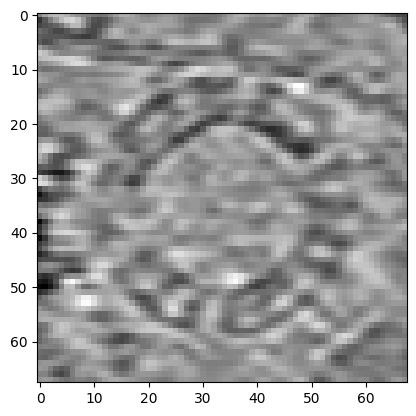

In [216]:
print(vol_samba[-1].shape)
plt.imshow(vol_samba[-1][vol_samba[-1].shape[0] // 2], cmap="grey")
plt.show()

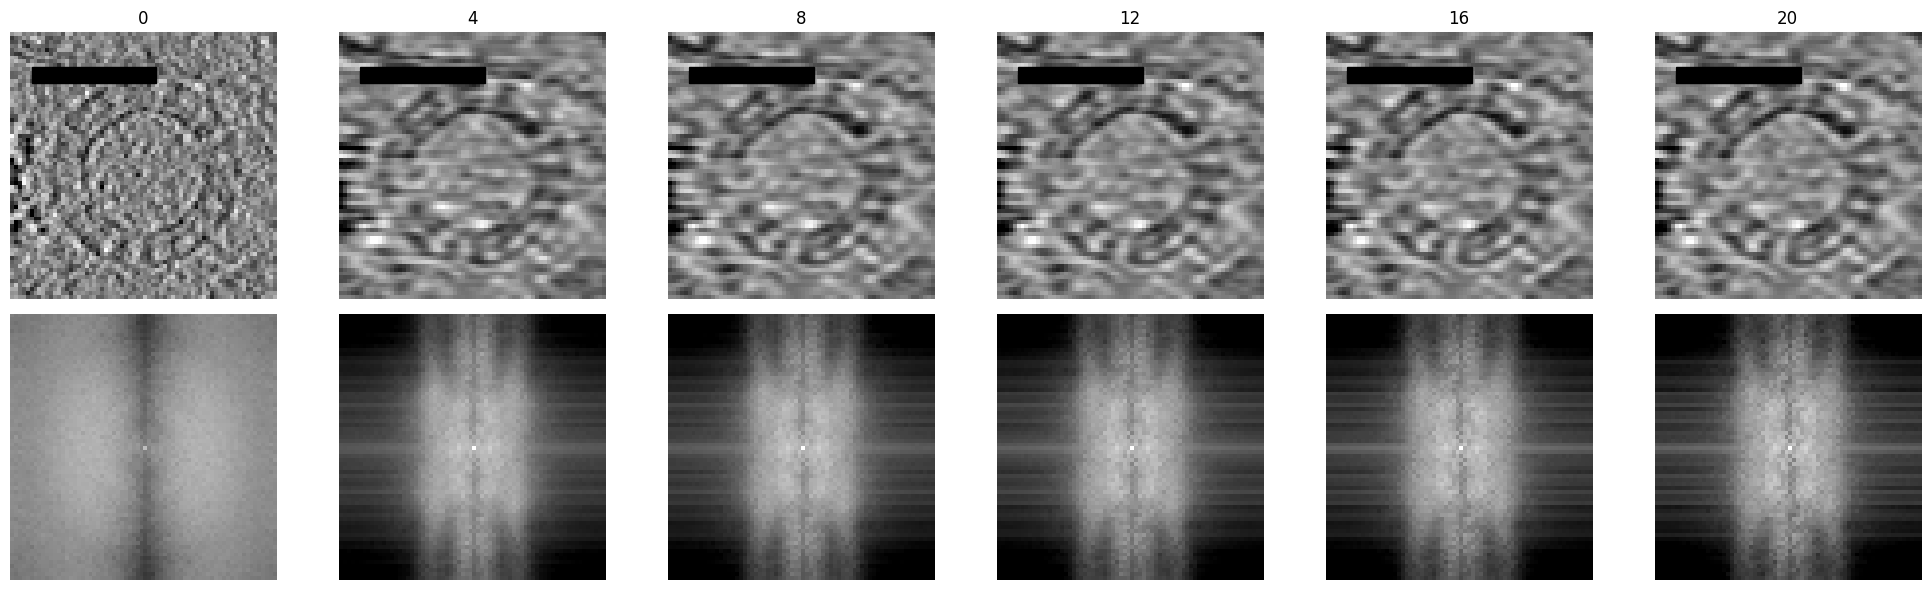

In [217]:
bin = 6
voxel_size = 2.62 * bin
scale_length, scale_width, scale_x0 = 500 / voxel_size, 25 / bin, (30 / bin, 50 / bin)

sigma = 3.5
vmin, vmax = 0.5 * (np.log(fft_raw)).min(), 0.5 * (np.log(fft_raw)).max()

fig, axs = plt.subplots(2, len(gap_list), figsize=(20, 6))
for i, gap in enumerate(gap_list):
    image = vol_samba[i][vol_samba[i].shape[0] // 2]
    fourier = np.log(fft_samba[i].mean(axis=0))
    img_bounds = sigma_bounds(image, sigma=sigma)

    ax = axs[0, i]
    ax.imshow(image, cmap="grey", vmin=img_bounds[0], vmax=img_bounds[1])
    ax.axis("off")
    ax.set_title(gap)
    scalebar = patches.Rectangle(
        scale_x0,
        scale_length,
        scale_width,
        linewidth=1,
        edgecolor="black",
        facecolor="black",
    )
    ax.add_patch(scalebar)

    ax = axs[1, i]
    ax.imshow(fourier, vmin=vmin, vmax=vmax, cmap="grey")
    ax.axis("off")

plt.tight_layout()
# plt.savefig('supp_fig_1A.svg', format='svg')
plt.show()

# Supp. Fig. 1B

In [82]:
start = time()

path_raw = "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_3x/gap_00/result.rec"

gap_list = np.arange(2, 20, 2)
# gap_list = np.arange(2,31)
path_samba = [
    "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_3x/gap_"
    + str(gap).zfill(2)
    + "/result.rec"
    for gap in gap_list
]

pad_z, pad_y, pad_x = [0, 0], [70, 70], [63, 77]
padding = [pad_z, pad_y, pad_x]

vol_raw = l2_normalize(load(path_raw, padding))
vol_samba = [l2_normalize(load(path, padding)) for path in path_samba]

fft_raw = spectrum(vol_raw)
fft_samba = [spectrum(vol) for vol in vol_samba]

print(time() - start)

3.280149221420288


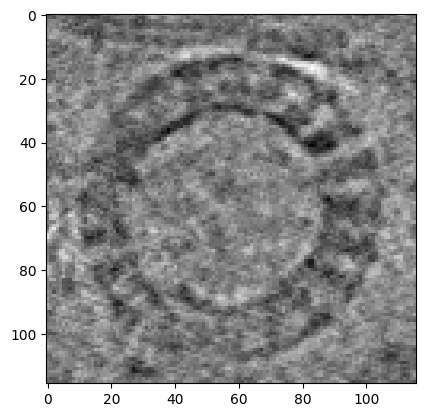

In [4]:
plt.imshow(vol_samba[-1][vol_samba[-1].shape[0] // 2], cmap="grey")
plt.show()

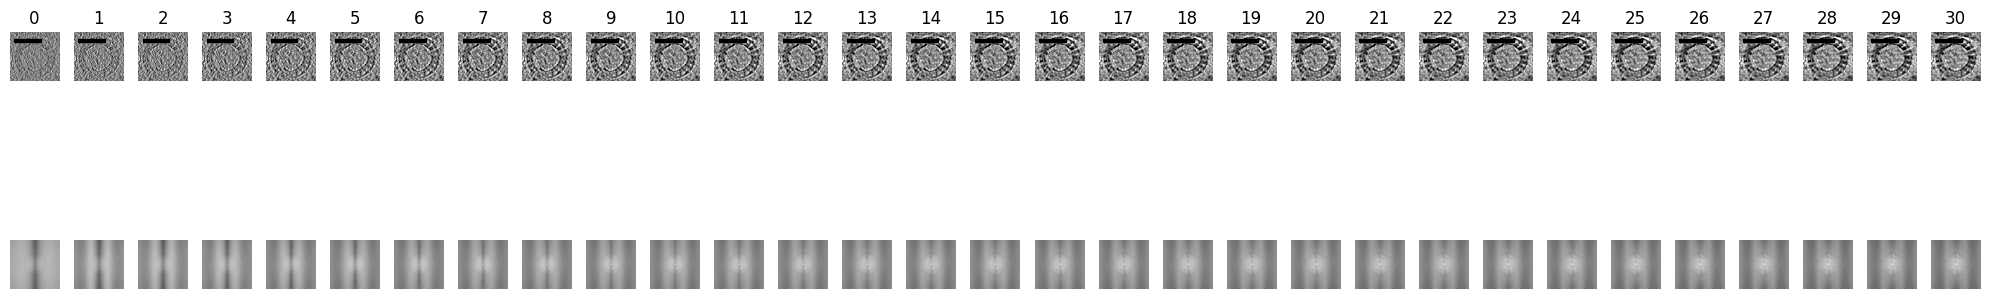

In [5]:
bin = 3
voxel_size = 2.62 * bin
scale_length, scale_width, scale_x0 = 500 / voxel_size, 25 / bin, (30 / bin, 50 / bin)

sigma = 2
vmin, vmax = 0.5 * (np.log(fft_raw)).min(), 0.5 * (np.log(fft_raw)).max()

fig, axs = plt.subplots(2, len(gap_list), figsize=(20, 6))
for i, gap in enumerate(gap_list):
    image = vol_samba[i][vol_samba[i].shape[0] // 2]
    fourier = np.log(fft_samba[i].mean(axis=0))
    img_bounds = sigma_bounds(image, sigma=sigma)

    ax = axs[0, i]
    ax.imshow(image, cmap="grey", vmin=img_bounds[0], vmax=img_bounds[1])
    ax.axis("off")
    ax.set_title(gap)
    scalebar = patches.Rectangle(
        scale_x0,
        scale_length,
        scale_width,
        linewidth=1,
        edgecolor="black",
        facecolor="black",
    )
    ax.add_patch(scalebar)

    ax = axs[1, i]
    ax.imshow(fourier, vmin=vmin, vmax=vmax, cmap="grey")
    ax.axis("off")

plt.tight_layout()
# plt.savefig('supp_fig_1B.svg', format='svg')
plt.show()

In [6]:
from skimage.metrics import structural_similarity


def PSNR(gt, target):  # Peak Signal-to-Noise Ratio
    MSE = np.sqrt(np.mean(np.abs(gt - target) ** 2))
    MAX = gt.max()
    return 10 * np.log10((MAX**2) / MSE)


def MAEM(gt, target):  # Mean Absolute Error-to-Maximum
    MAE = np.mean(np.abs(gt - target) ** 1)
    MAX = gt.max()
    return (MAX - MAE) / MAX


def SSIM(gt, target):  # Structural Similarity Index Measure
    return structural_similarity(gt, target, data_range=gt.max() - gt.min())


### No-reference metrics


def auto_metric(original, denoised):
    residual = original - denoised
    if np.max(np.abs(residual)) == 0:
        return 1
    N = structural_similarity(original, residual, data_range=512, full=True)[
        1
    ].flatten()
    P = structural_similarity(original, denoised, data_range=512, full=True)[
        1
    ].flatten()
    score = np.corrcoef(N, P)
    return 1 - np.abs(score[0, 1])


def derivative(stack):
    di = np.roll(stack, 1, axis=0) - stack
    dj = np.roll(stack, 1, axis=1) - stack
    dk = np.roll(stack, 1, axis=2) - stack
    return np.maximum(np.abs(di), np.abs(dj), np.abs(dk))


def edge_metric(original, denoised):
    eps = 1e-4
    dx = derivative(original)
    dy = derivative(denoised)
    dy, dx = dy / np.max(dx), dx / np.max(dx)
    D = np.abs(dx - dy)
    threshold = np.mean(dx)
    Q1 = 1 - np.mean(D[D > threshold]) if threshold < np.max(dx) else 1
    Q2 = np.mean(D[D <= threshold]) if threshold > np.min(dx) else 0
    DRM = (2 * Q1 * Q2 + eps) / (Q1**2 + Q2**2 + eps)
    return 1 - DRM

In [208]:
max_gap = gap_list[-1]

psnr_plot = [PSNR(vol_raw[max_gap:-max_gap], x[max_gap:-max_gap]) for x in vol_samba]
maem_plot = [MAEM(vol_raw[max_gap:-max_gap], x[max_gap:-max_gap]) for x in vol_samba]
ssim_plot = [SSIM(vol_raw[max_gap:-max_gap], x[max_gap:-max_gap]) for x in vol_samba]

auto_plot = [
    auto_metric(vol_raw[max_gap:-max_gap], x[max_gap:-max_gap]) for x in vol_samba
]
edge_plot = [
    edge_metric(vol_raw[max_gap:-max_gap], x[max_gap:-max_gap]) for x in vol_samba
]

In [ ]:
plt.plot(psnr_plot)
plt.show()
plt.plot(maem_plot)
plt.show()
plt.plot(ssim_plot)
plt.show()
plt.plot(auto_plot)
plt.show()
plt.plot(edge_plot)
plt.show()

In [83]:
def calculate_FSC(im1, im2, batch_size=10):
    # Assert both images have same shape
    assert im1.shape == im2.shape, "Images must have same dimensions."

    # Get Fourier Transform of both images
    im1_ft = np.fft.fftshift(np.fft.fftn(im1))
    im2_ft = np.fft.fftshift(np.fft.fftn(im2))

    # Calculate the radii of each point in the FFT
    size = np.array(im1.shape)
    center = size // 2
    if im1.ndim == 2:
        y, x = np.ogrid[-center[0] : center[0], -center[1] : center[1]]
        radii = np.sqrt(x**2 + y**2)
    elif im1.ndim == 3:
        y, x, z = np.ogrid[
            -center[0] : center[0], -center[1] : center[1], -center[2] : center[2]
        ]
        radii = np.sqrt(x**2 + y**2 + z**2)

    # Truncate to a histogram bin every 'bins' units
    max_radius = np.max(radii)
    bins = np.arange(np.ceil(max_radius))
    digitized = np.digitize(radii.flat, bins)

    # Convert shell indices to spatial frequencies
    spatial_scales = (2 * im1.shape[0]) / np.arange(1, len(bins))

    # Perform shell (annulus) summation
    data1 = (im1_ft).flatten()
    data2 = (im2_ft).flatten()

    #     n_jobs = np.minimum(int(len(bins)/batch_size),multiprocessing.cpu_count())
    n_jobs = -1

    def loop1(i):
        return data1[digitized == i]

    def loop2(i):
        return data2[digitized == i]

    c1 = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
        delayed(loop1)(i) for i in range(1, len(bins))
    )
    c2 = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
        delayed(loop2)(i) for i in range(1, len(bins))
    )
    n_per_r = np.asarray([cc.shape for cc in c1]).squeeze()

    # FSC curve
    fsc = np.array(
        [
            np.abs(np.sum(np.conj(c1[i]) * c2[i]))
            / np.sqrt(
                np.abs(np.sum(np.conj(c1[i]) * c1[i]))
                * np.abs(np.sum(np.conj(c2[i]) * c2[i]))
            )
            for i in range(len(c1))
        ]
    )
    print("done")
    return fsc, spatial_scales


def checkerboard_split(image):
    # Make an index chess board structure
    shape = image.shape
    odd_index = list(np.arange(1, shape[i], 2) for i in range(len(shape)))
    even_index = list(np.arange(0, shape[i], 2) for i in range(len(shape)))

    # Create the two pseudo images
    if image.ndim == 2:
        image1 = image[odd_index[0], :][:, odd_index[1]]
        image2 = image[even_index[0], :][:, even_index[1]]
    else:
        image1 = (
            image[even_index[0], :, :][:, odd_index[1], :][:, :, odd_index[2]]
            + image[odd_index[0], :, :][:, odd_index[1], :][:, :, odd_index[2]]
        )
        image2 = (
            image[even_index[0], :, :][:, even_index[1], :][:, :, even_index[2]]
            + image[odd_index[0], :, :][:, even_index[1], :][:, :, even_index[2]]
        )
    return image1, image2


def self_fsc(img, batch_size=10):
    img1, img2 = checkerboard_split(img)
    fsc = calculate_FSC(img1, img2, batch_size)
    return fsc

In [84]:
max_gap = gap_list[-1]
spatial_scales = calculate_FSC(vol_raw[max_gap:-max_gap], vol_raw[max_gap:-max_gap])[1]
fsc_list = [
    calculate_FSC(vol_raw[max_gap:-max_gap], x[max_gap:-max_gap])[0] for x in vol_samba
]
# fsc_list = [calculate_FSC(vol_raw[max_gap:-max_gap,:,vol_raw.shape[2]//2], x[max_gap:-max_gap,:,vol_raw.shape[2]//2]) for x in vol_samba]
# fsc_list = [calculate_FSC(vol_raw[max_gap:-max_gap], vol_raw[max_gap:-max_gap]-x[max_gap:-max_gap]) for x in vol_samba]

done
done
done
done
done
done
done
done
done
done


12


/tmp/ipykernel_4085473/3482735276.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn', len(gap_list))


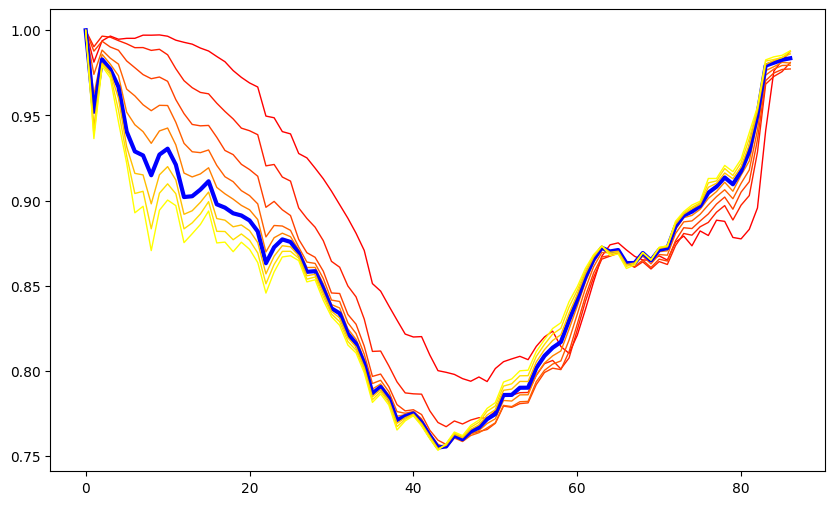

In [86]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.get_cmap("autumn", len(gap_list))
colors = [cmap(i) for i in range(len(gap_list))]

i = 5
colors[i] = "blue"
print(gap_list[i])

plt.figure(figsize=(10, 6))
for fsc, gap, color in zip(fsc_list, gap_list, colors):
    plt.plot(fsc, label=str(gap), color=color, linewidth=(3 if color == "blue" else 1))
# plt.legend()
plt.show()

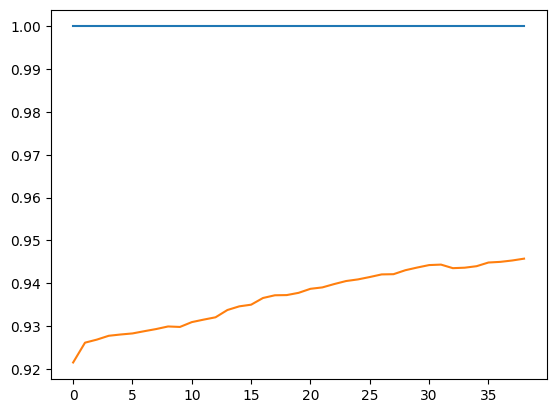

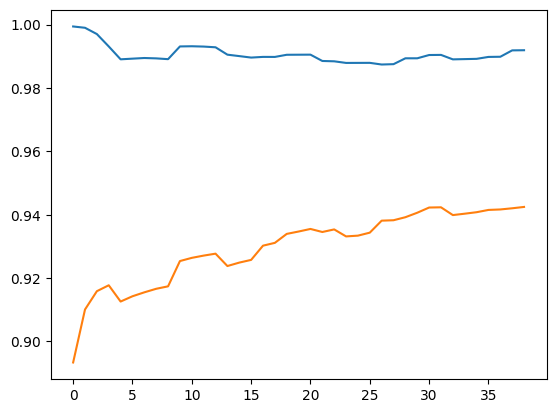

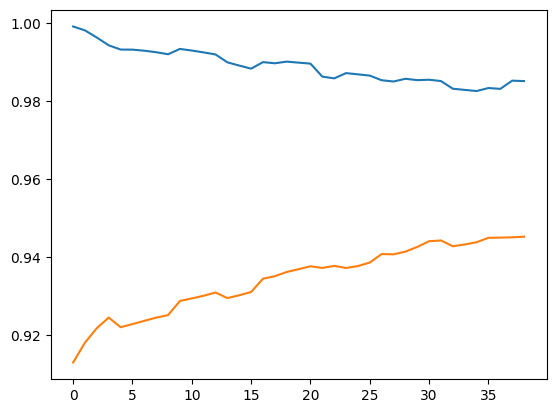

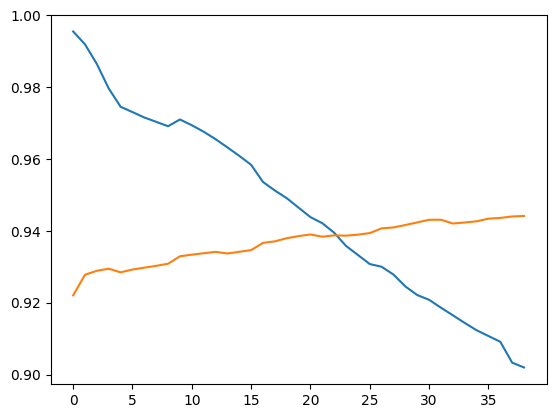

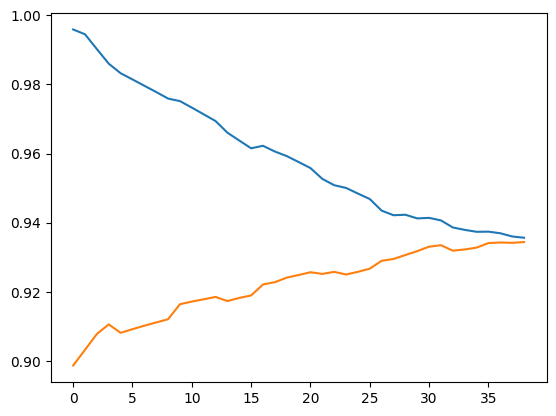

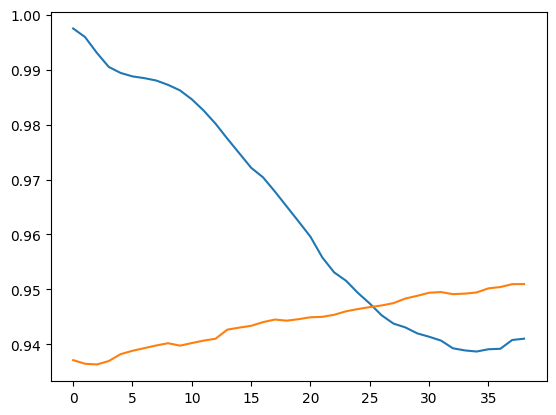

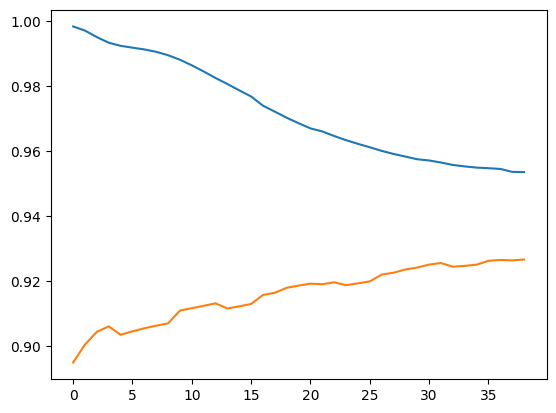

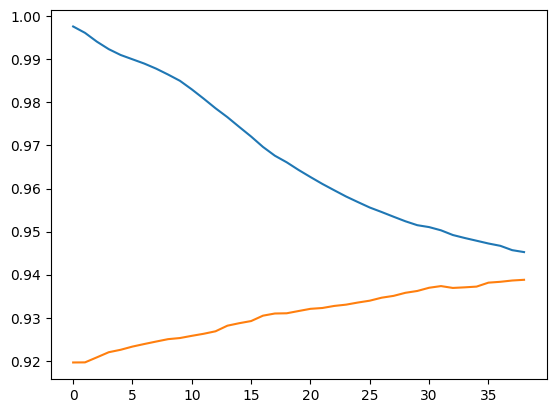

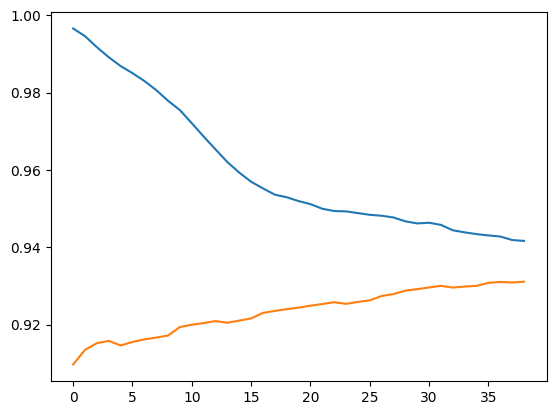

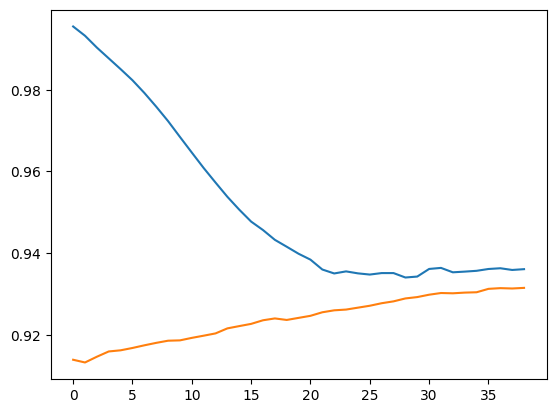

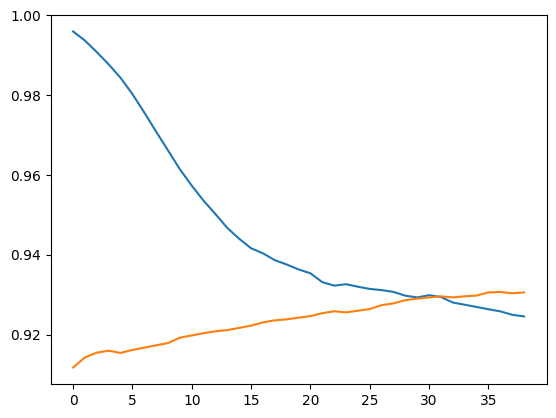

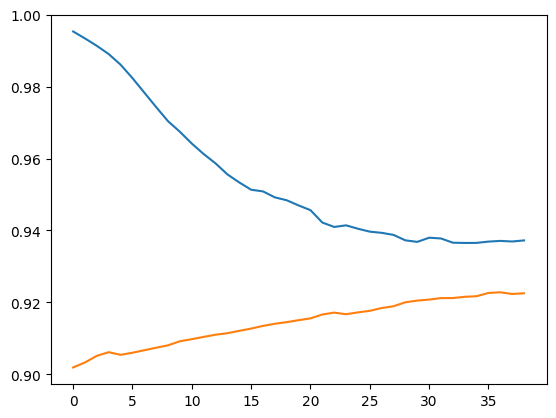

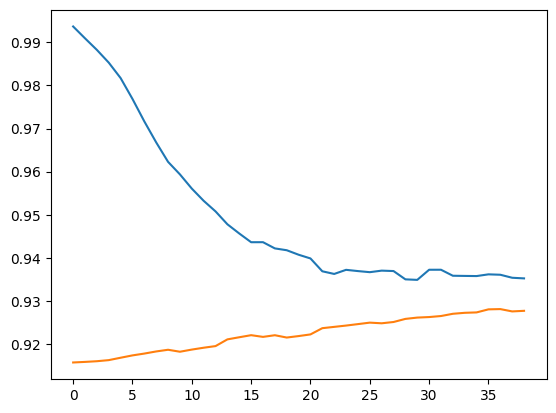

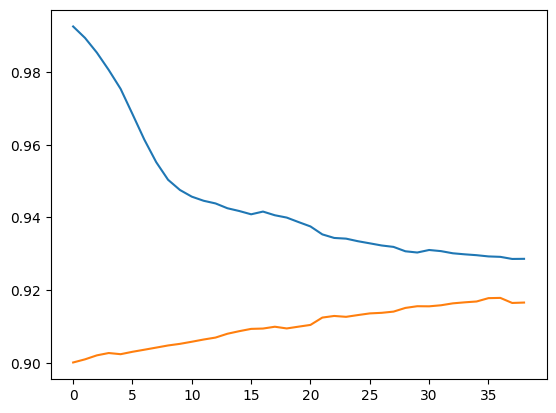

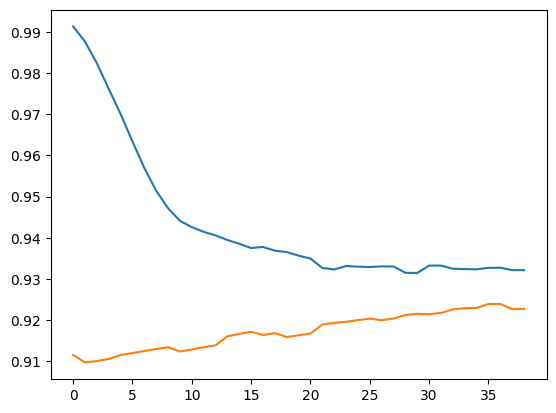

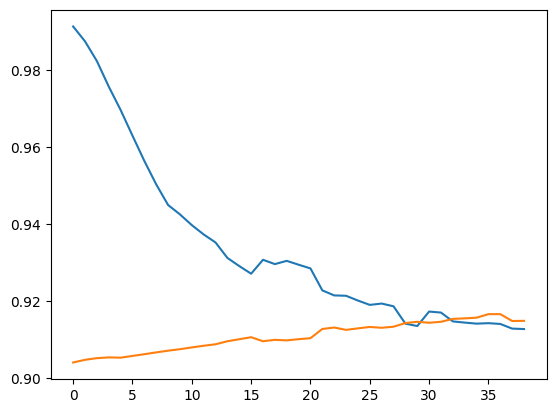

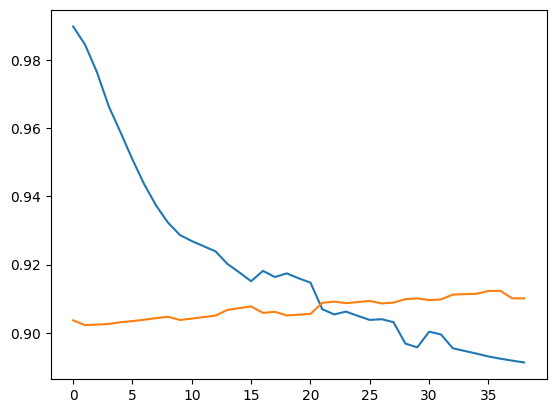

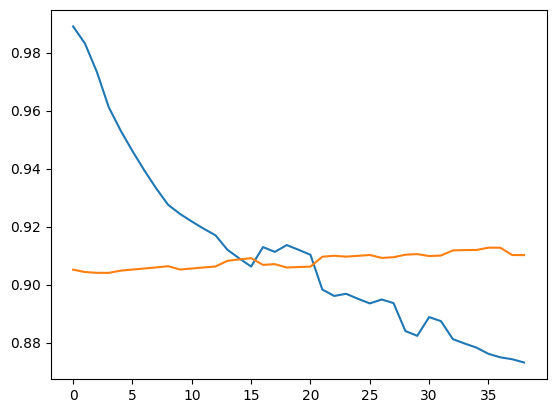

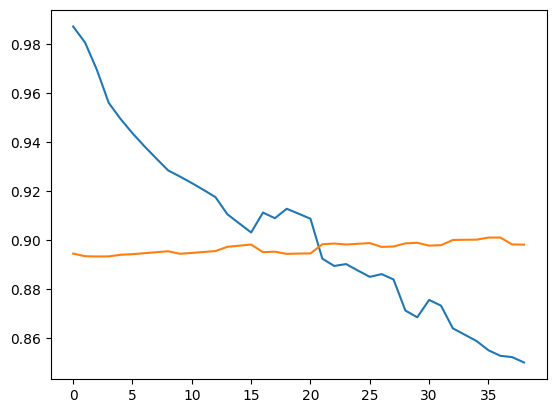

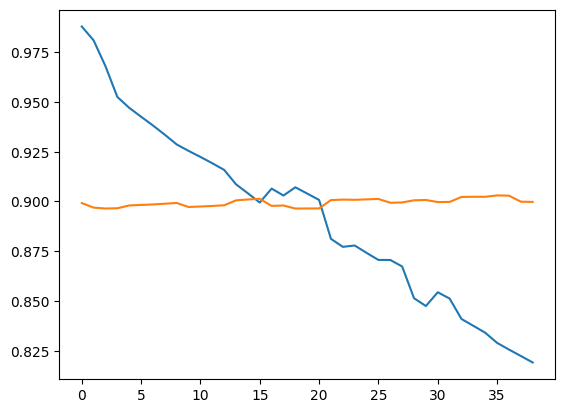

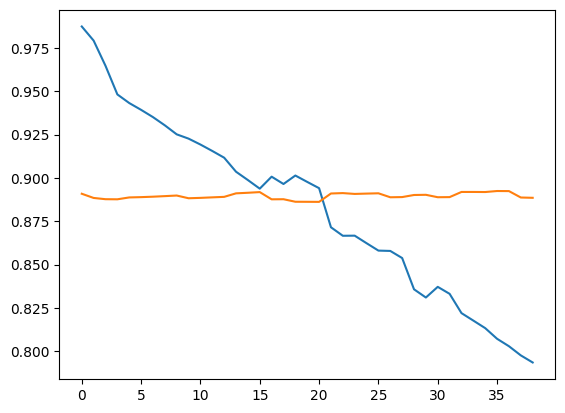

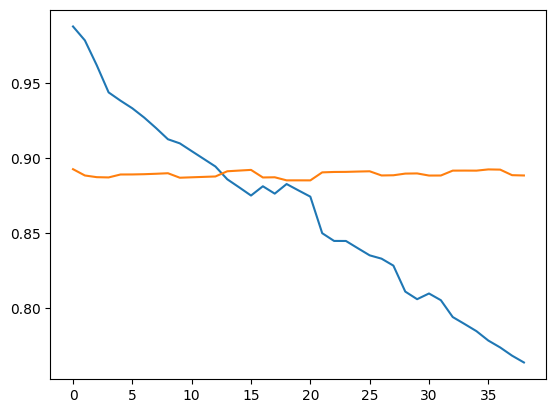

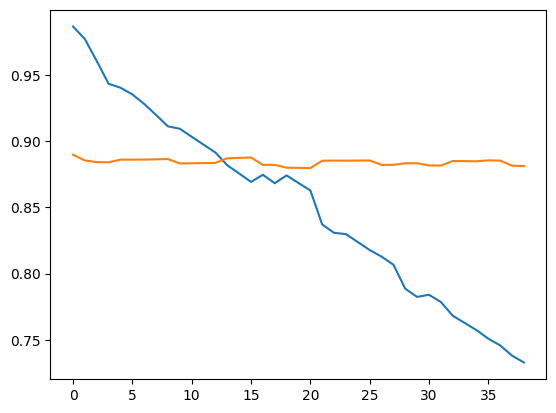

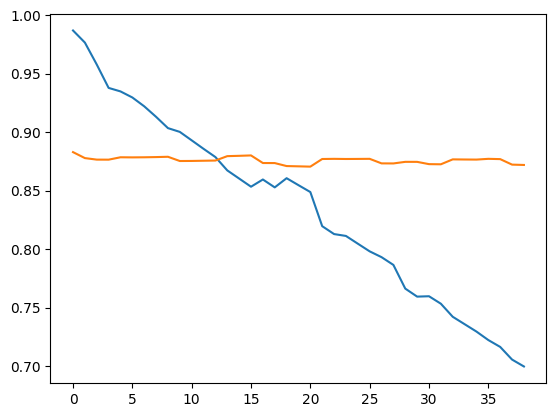

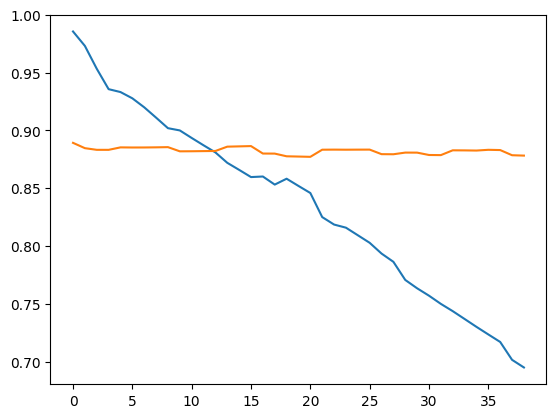

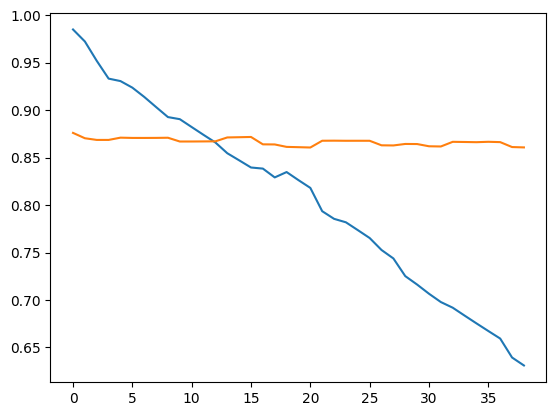

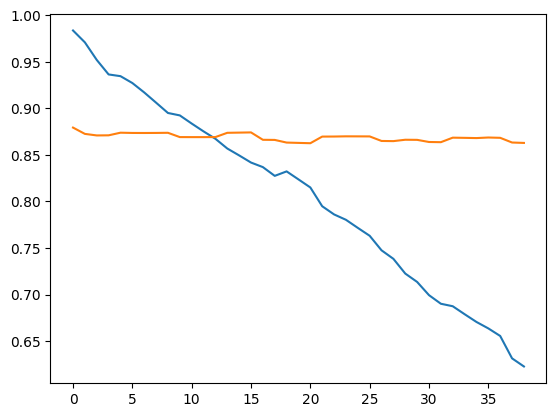

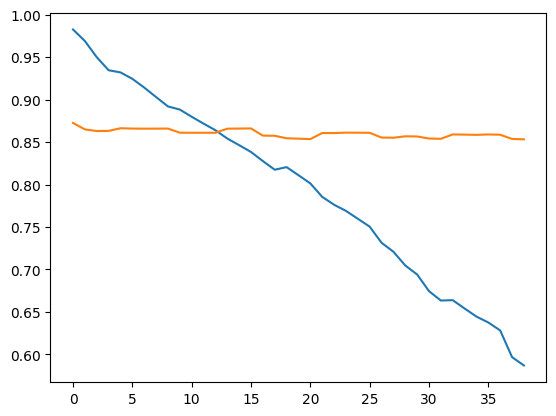

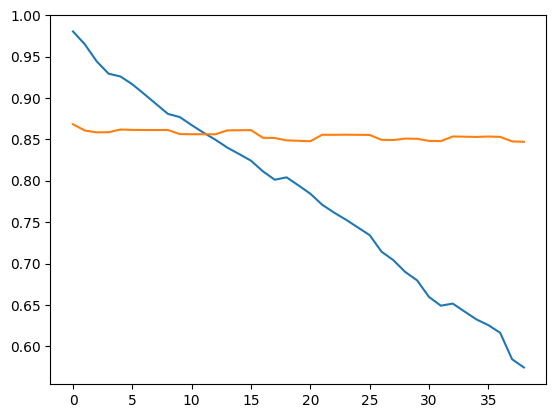

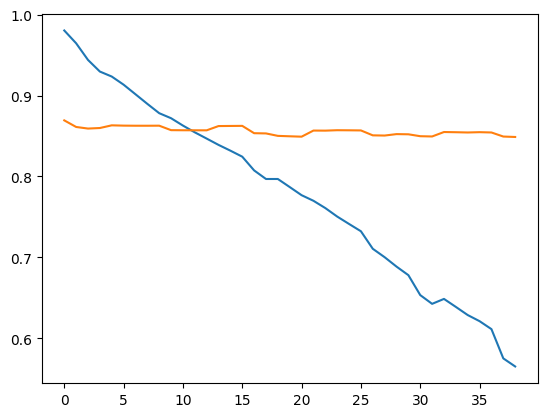

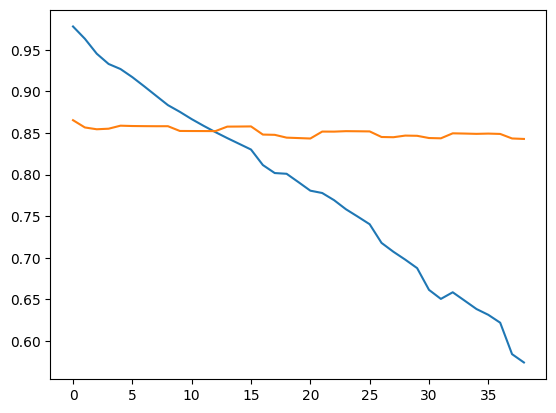

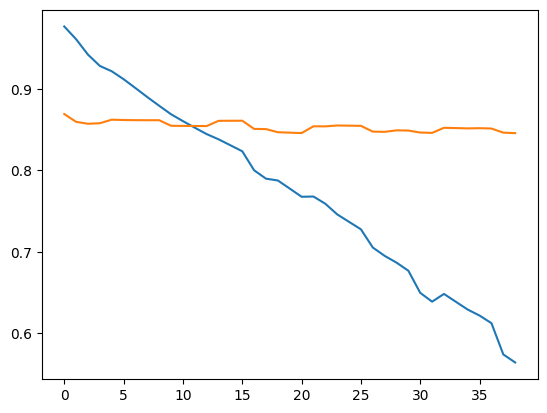

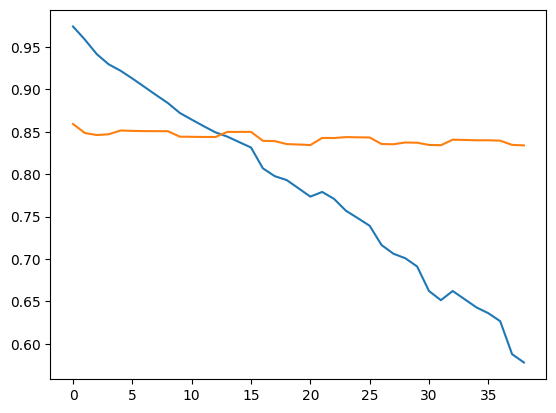

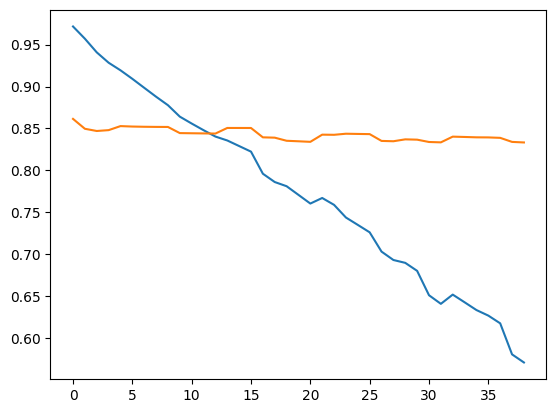

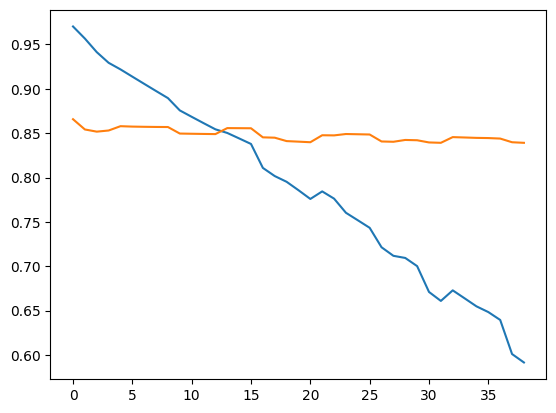

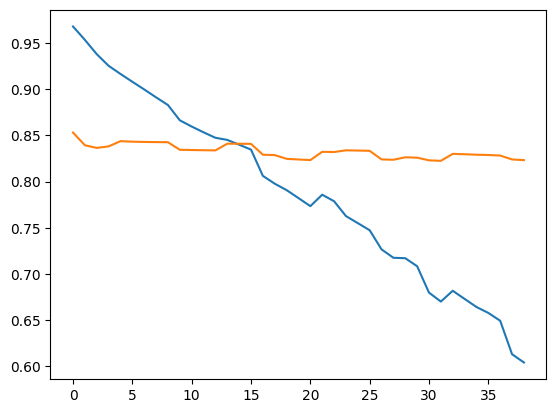

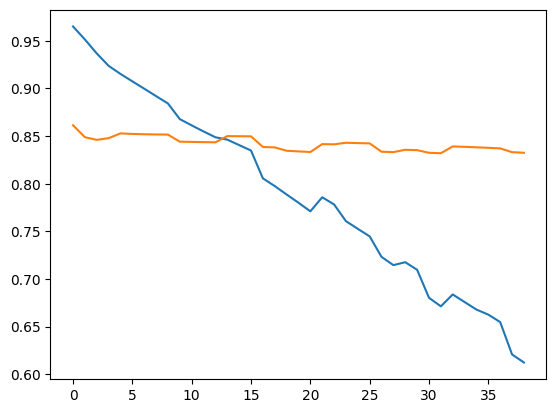

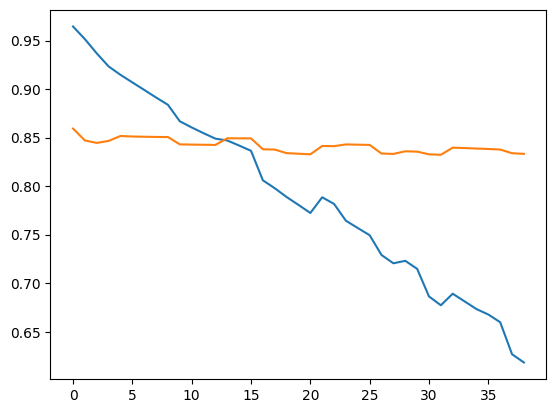

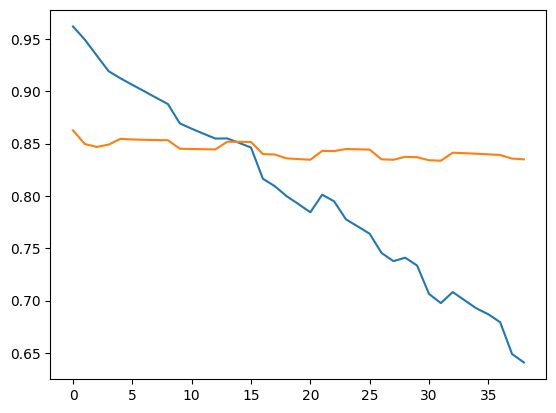

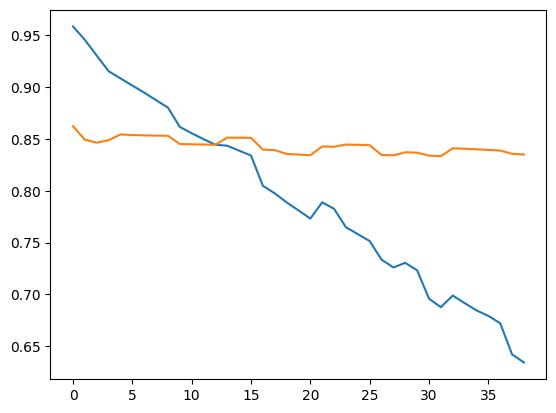

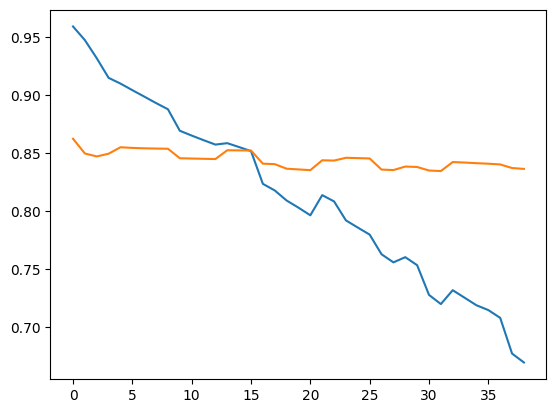

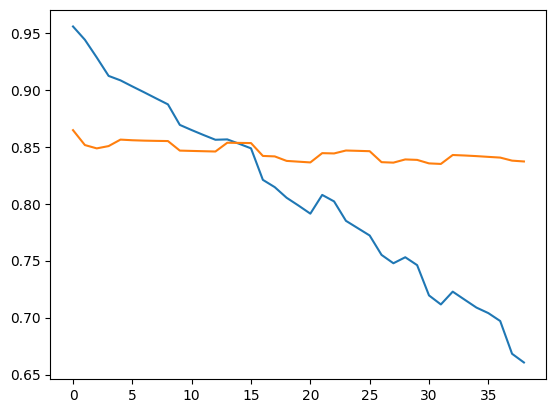

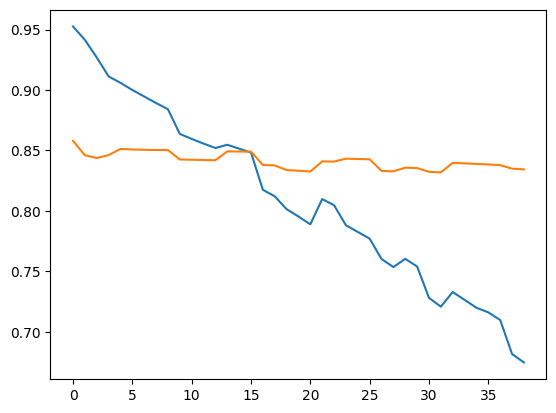

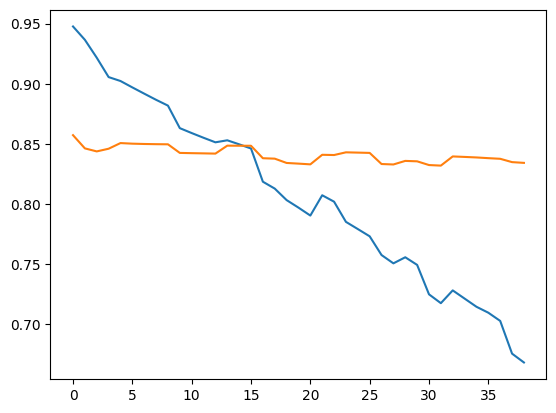

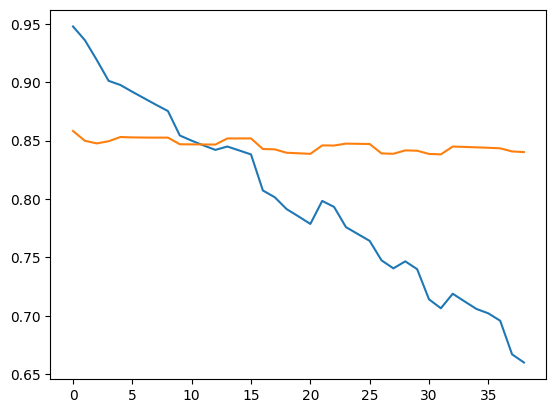

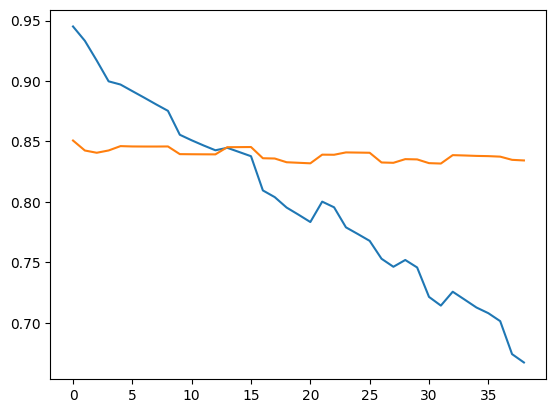

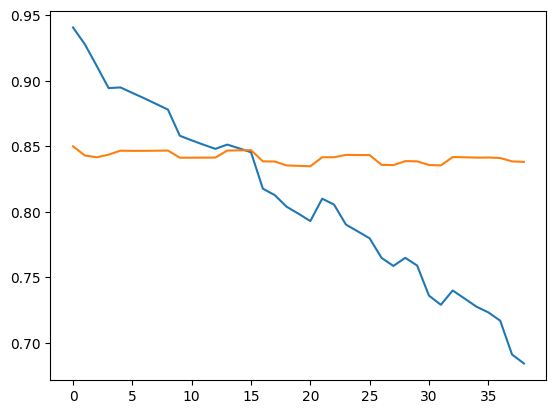

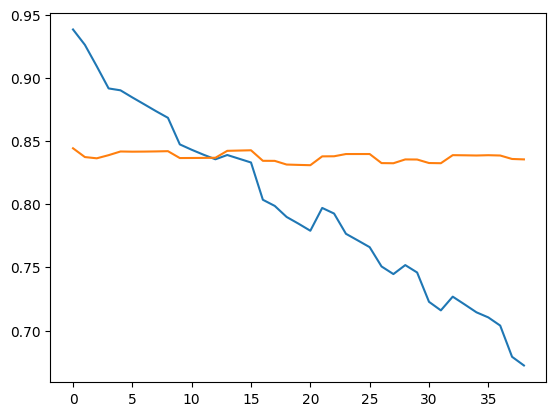

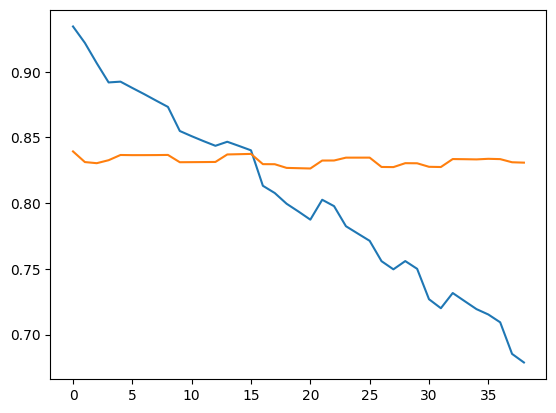

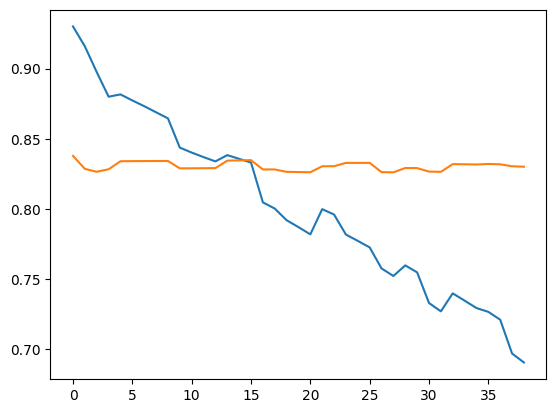

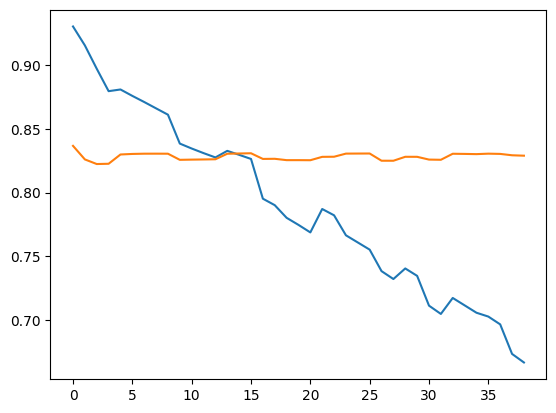

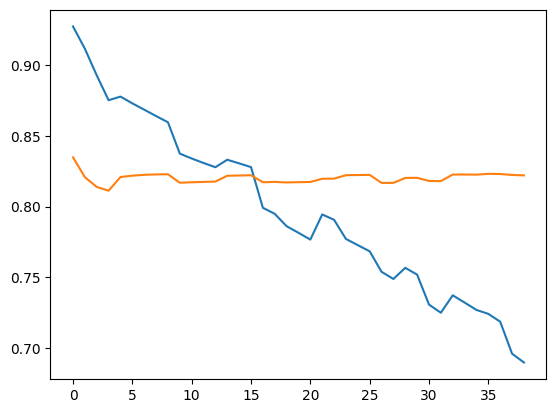

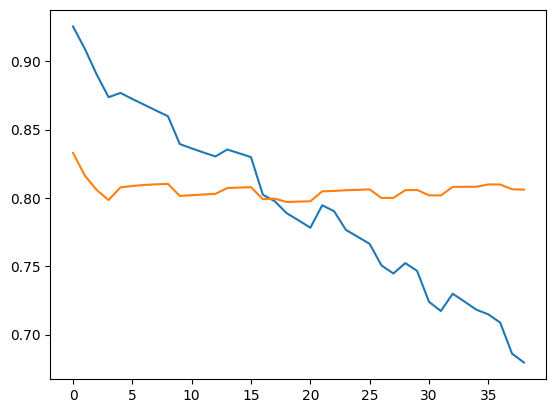

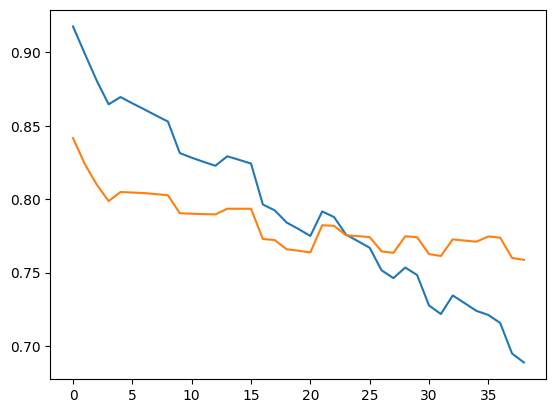

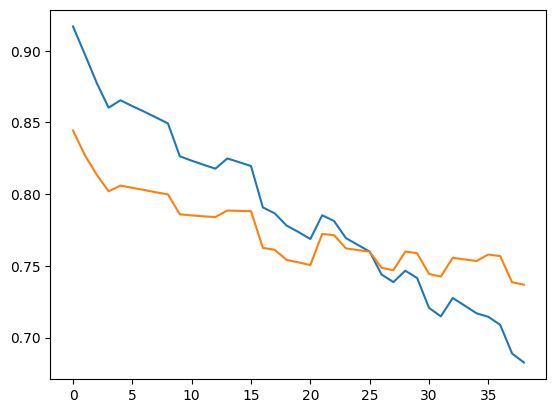

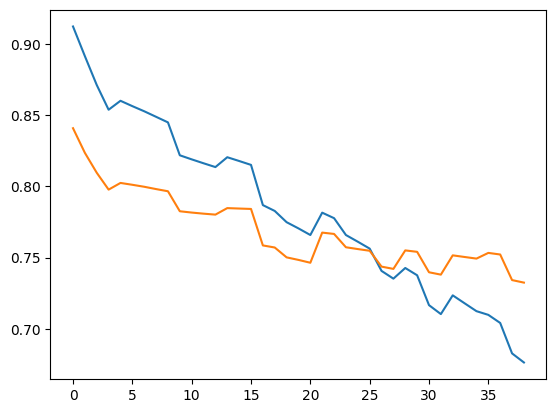

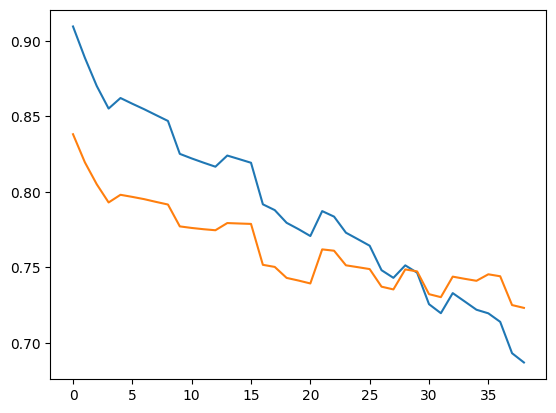

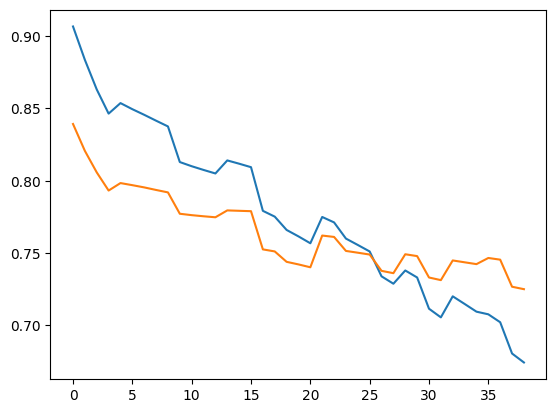

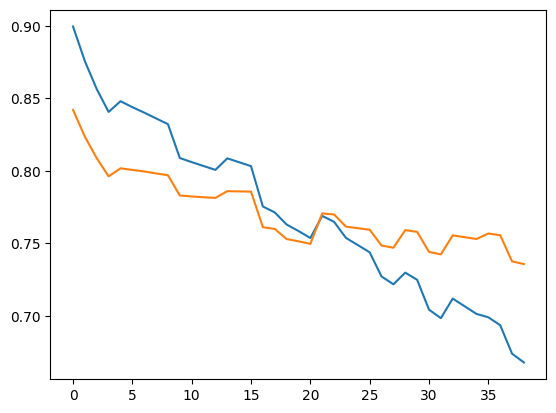

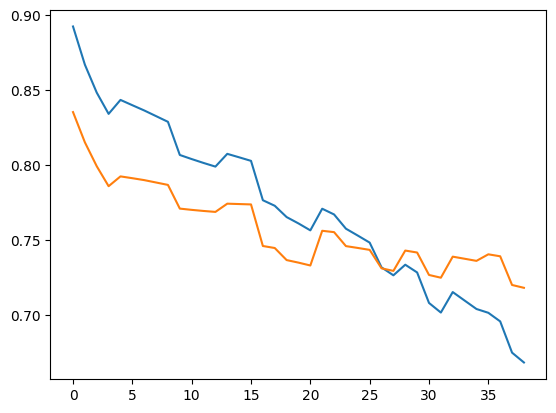

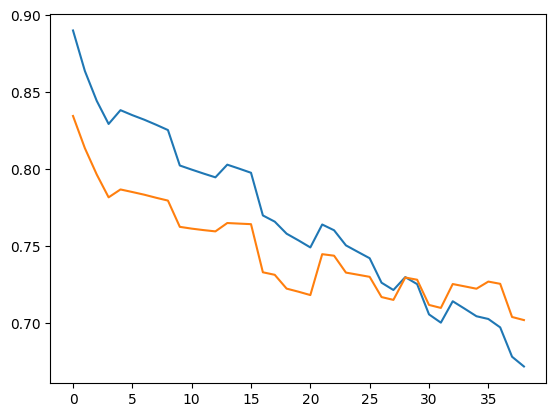

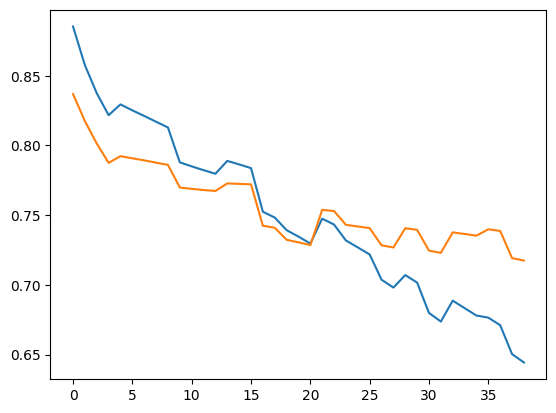

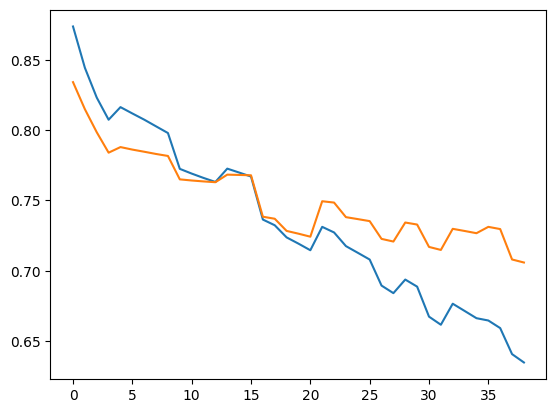

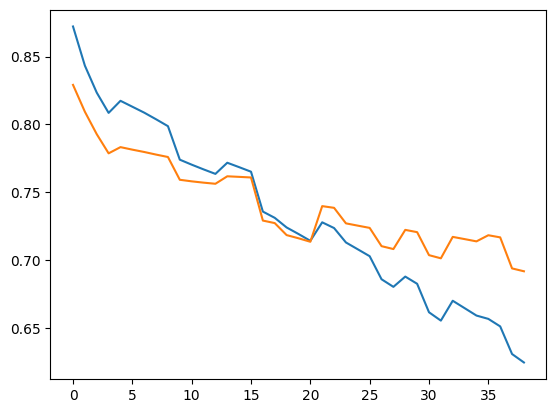

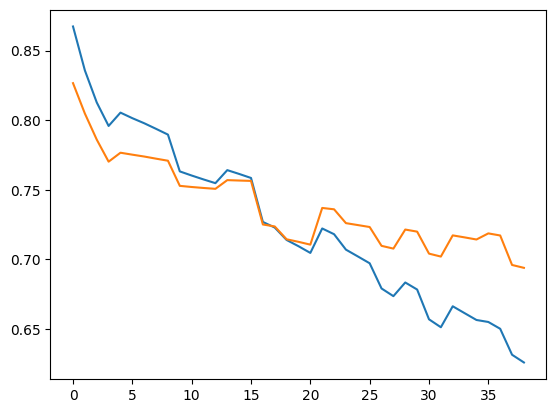

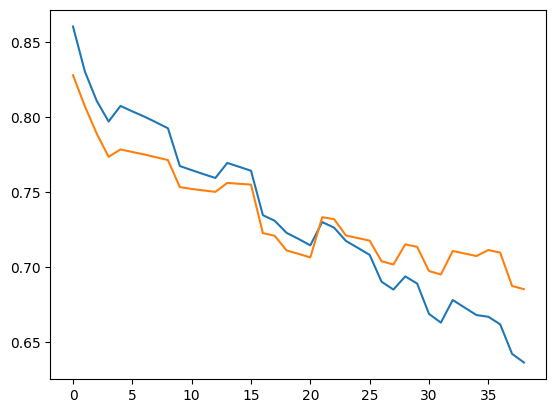

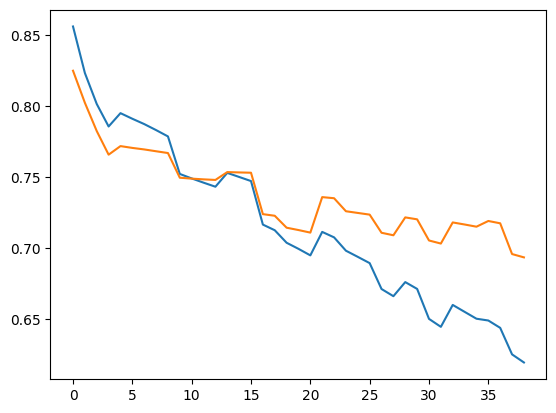

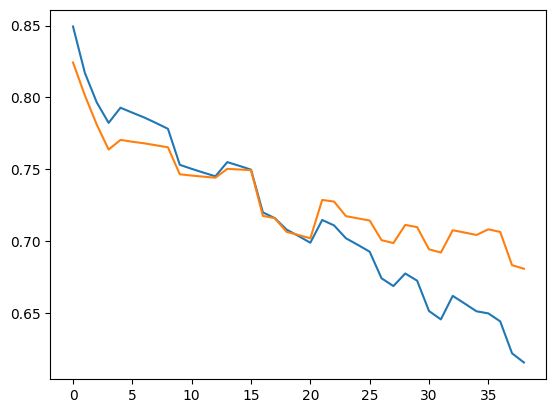

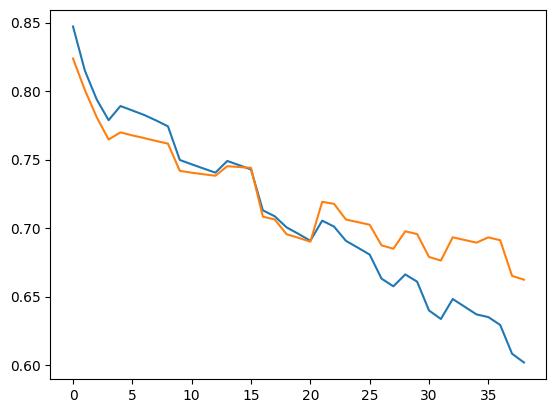

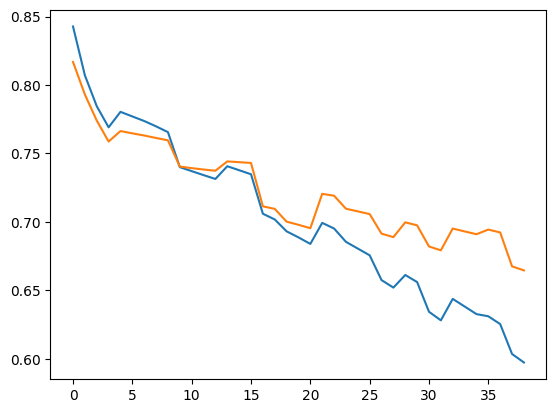

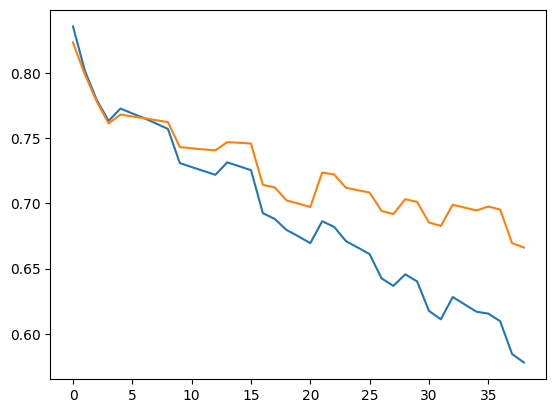

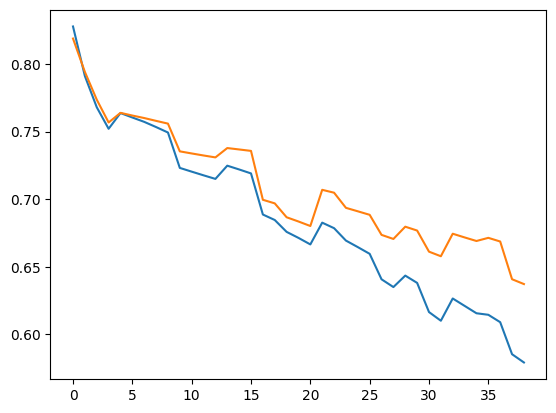

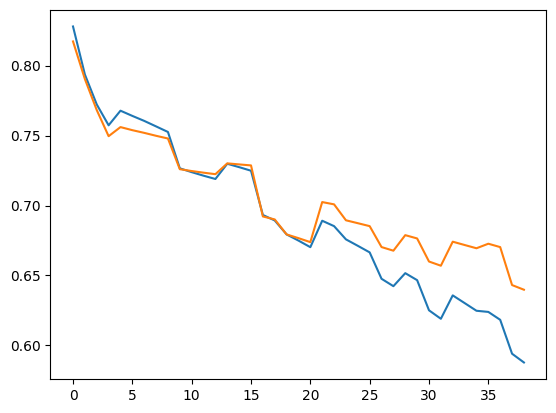

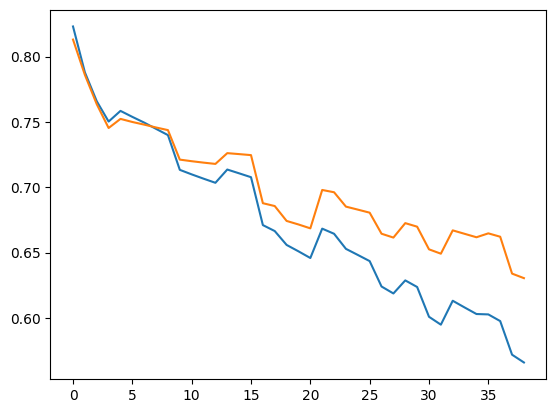

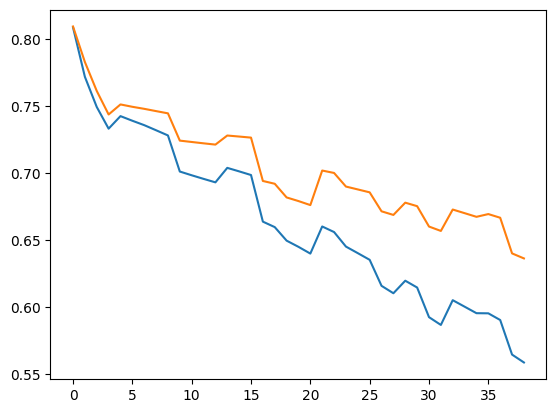

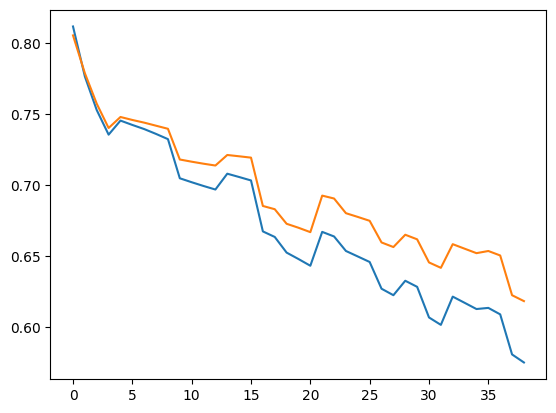

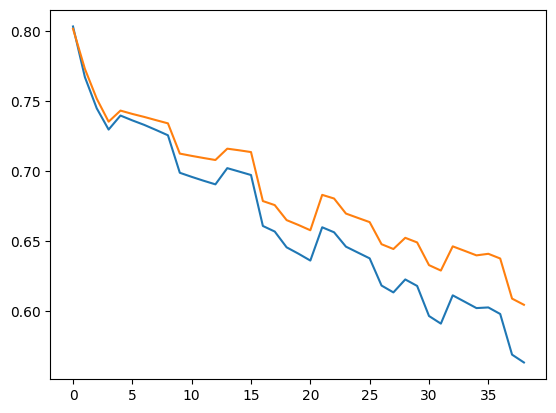

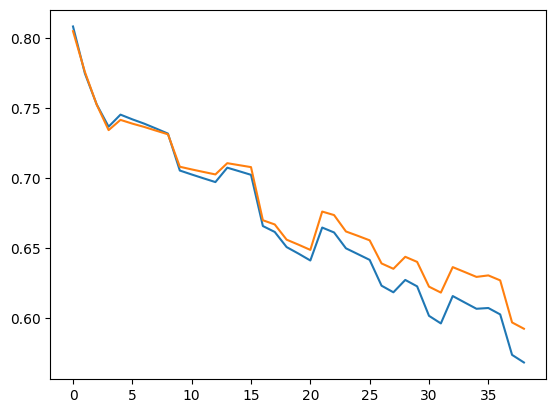

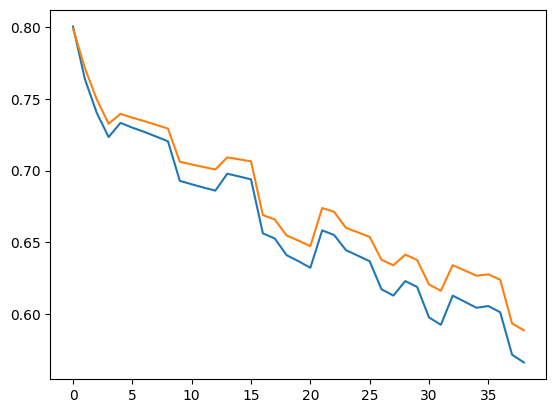

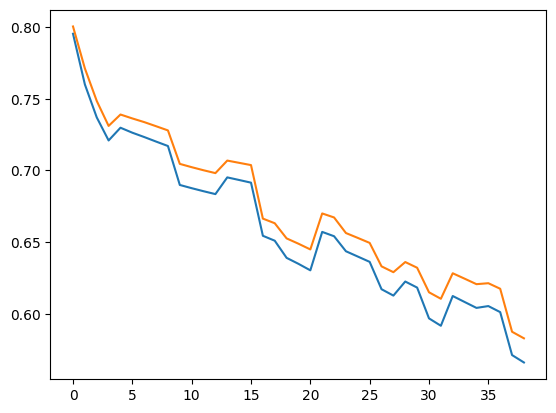

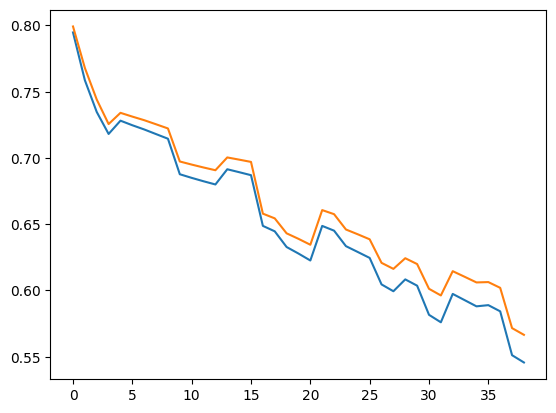

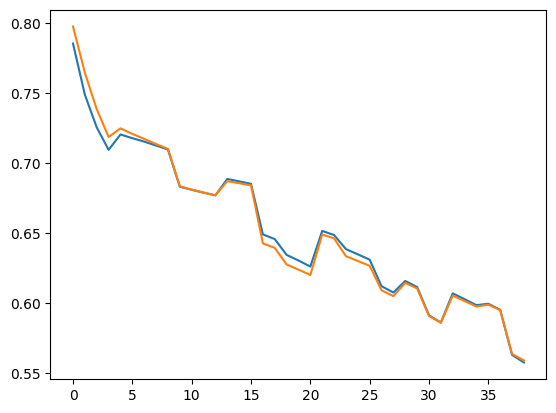

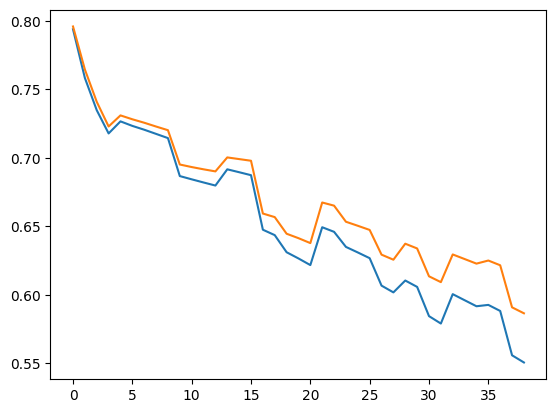

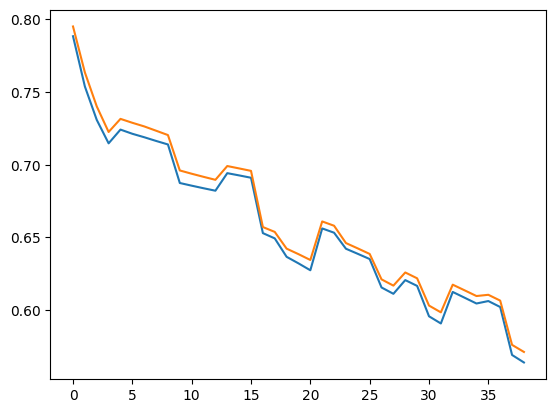

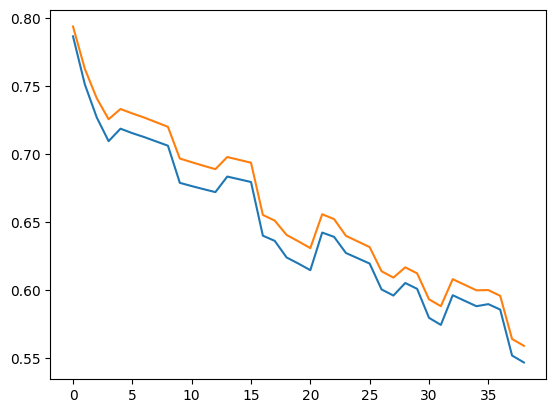

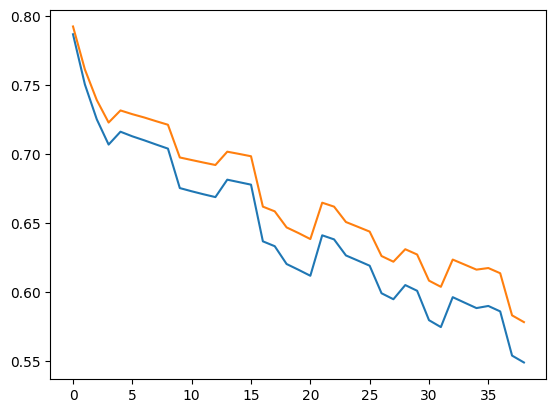

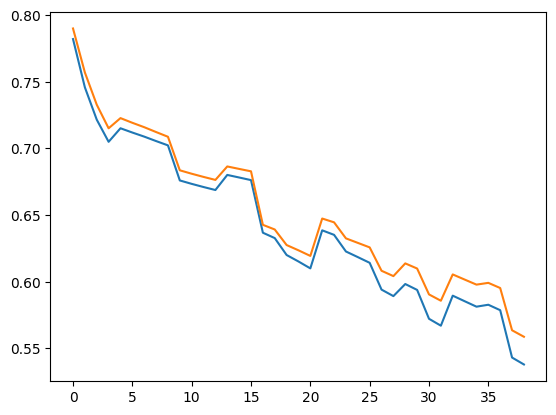

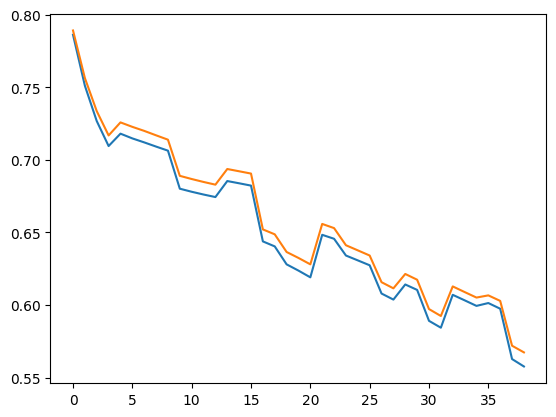

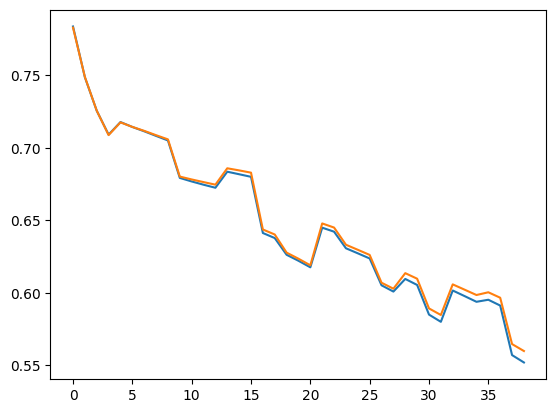

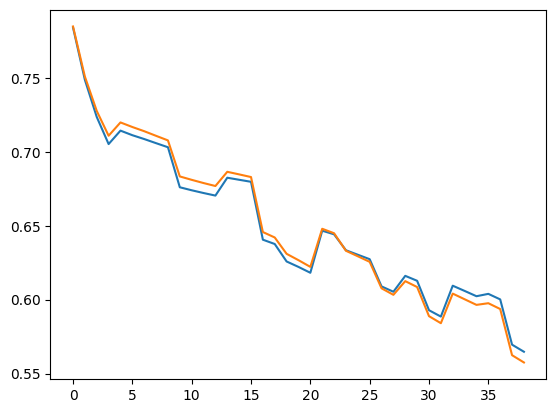

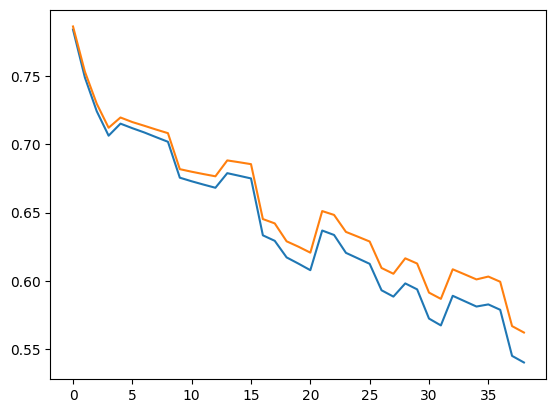

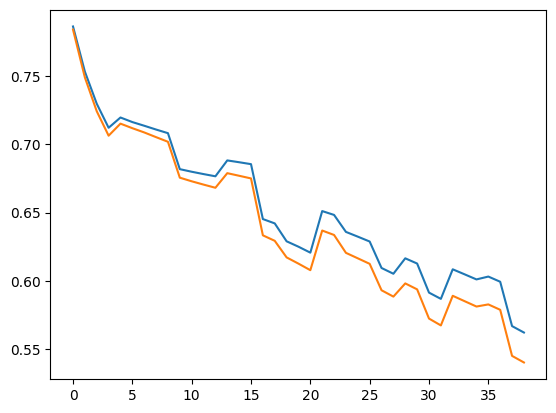

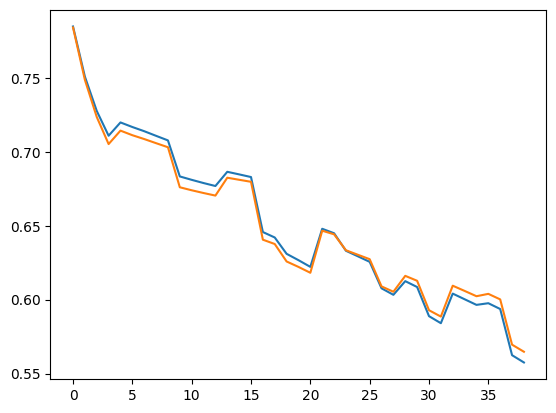

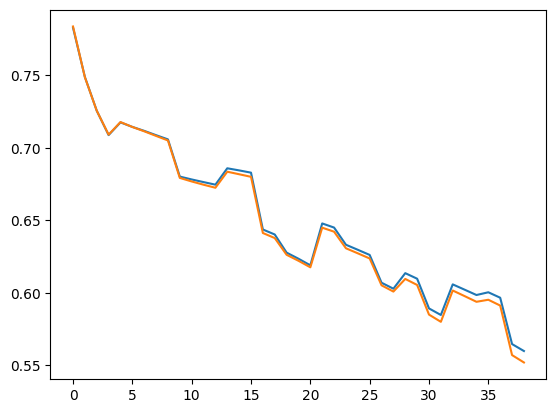

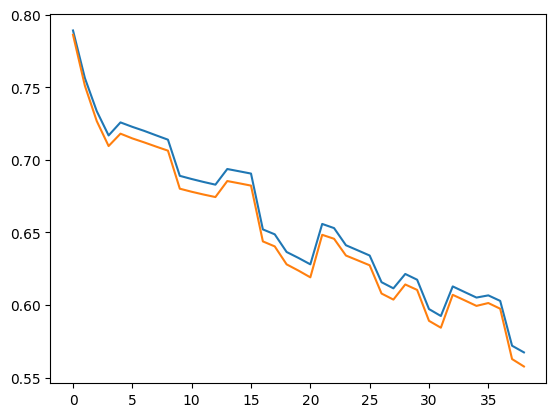

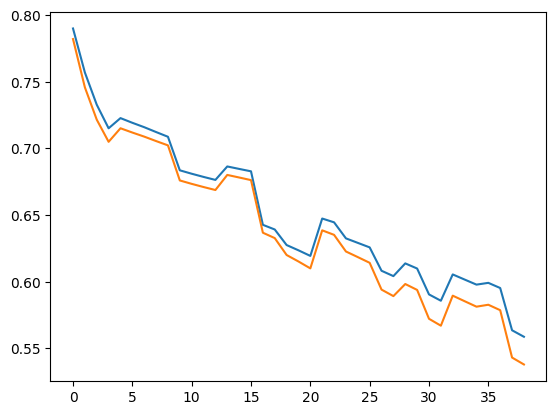

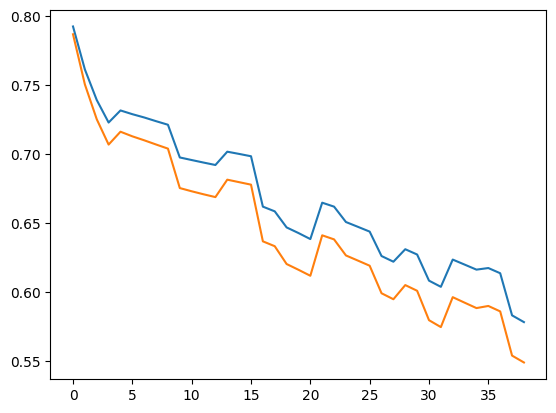

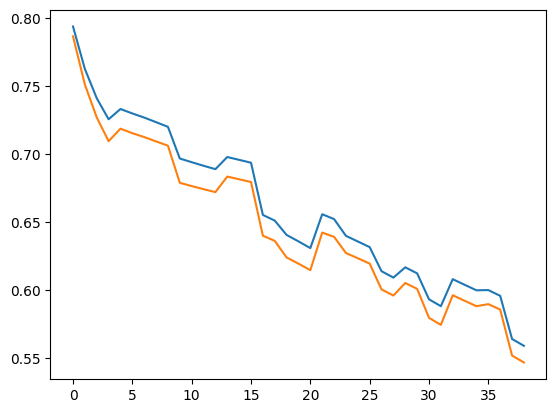

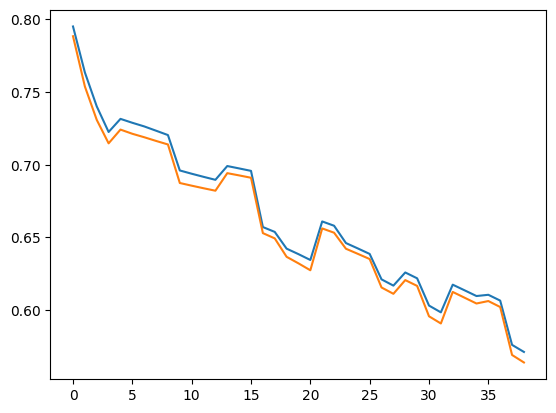

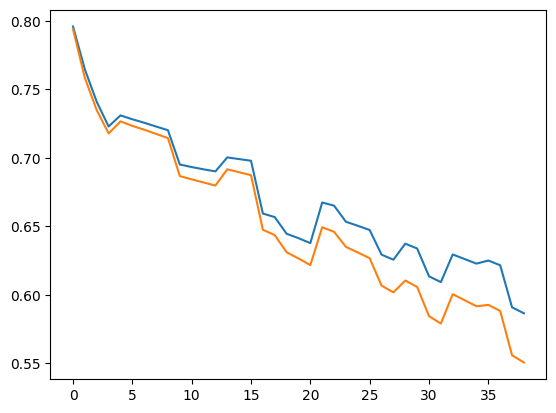

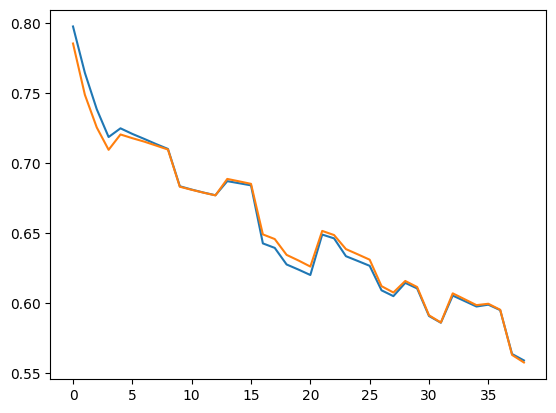

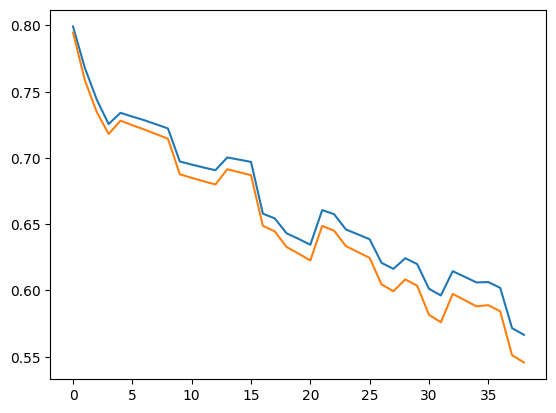

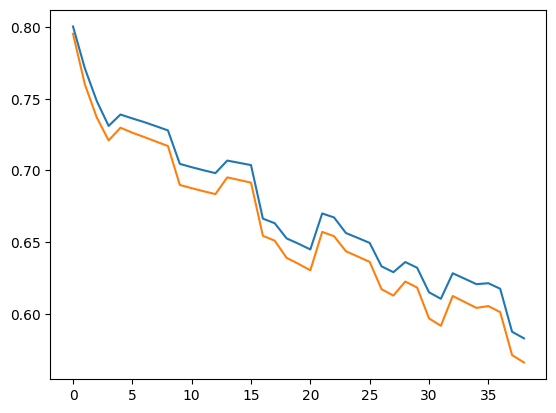

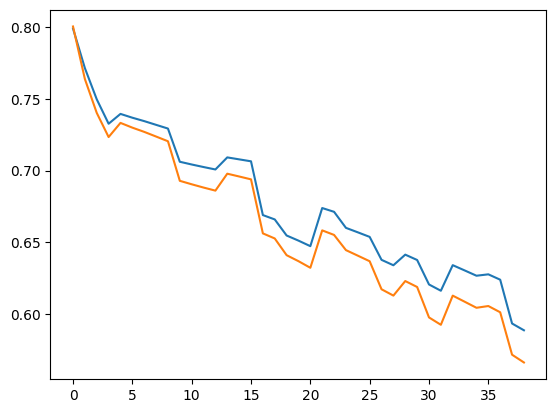

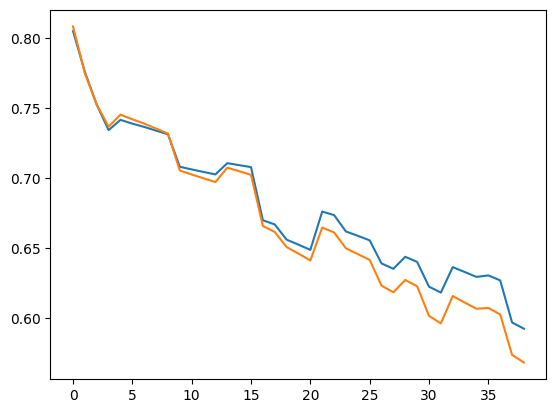

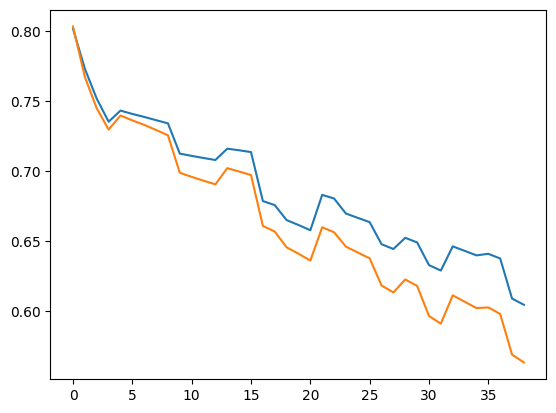

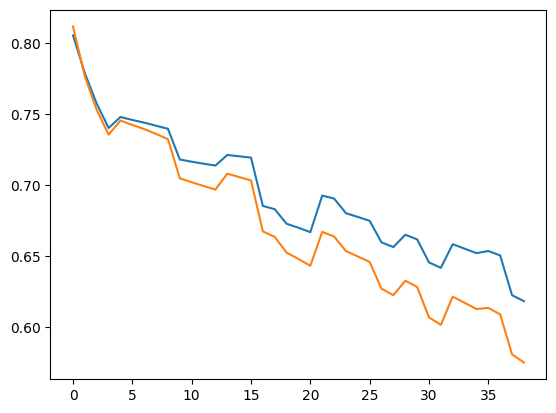

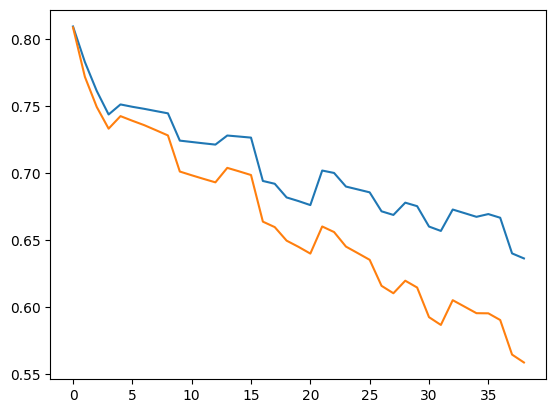

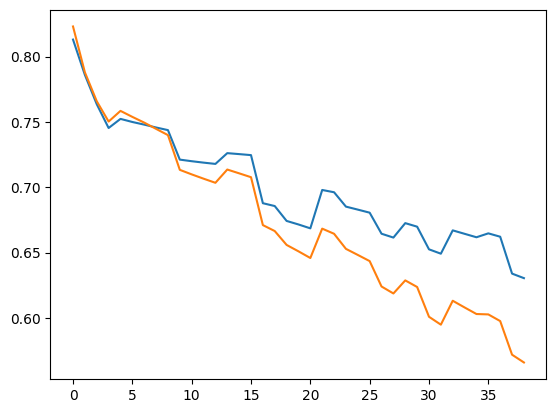

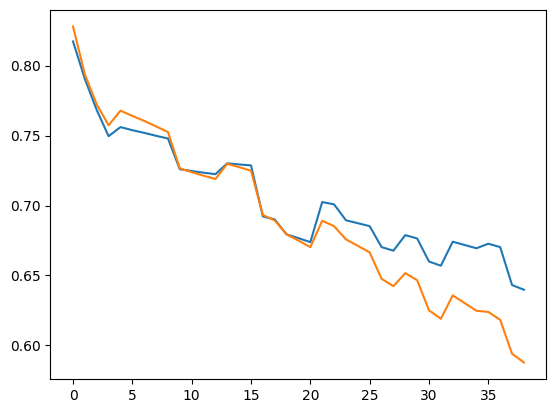

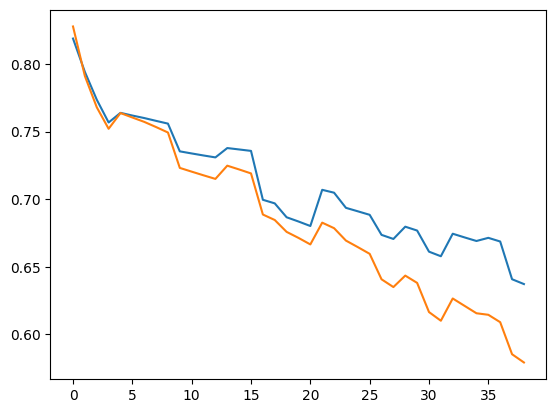

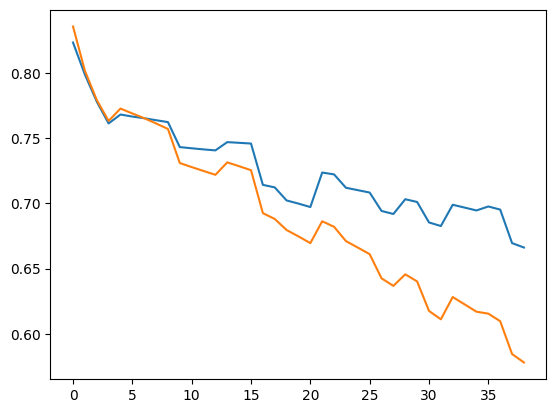

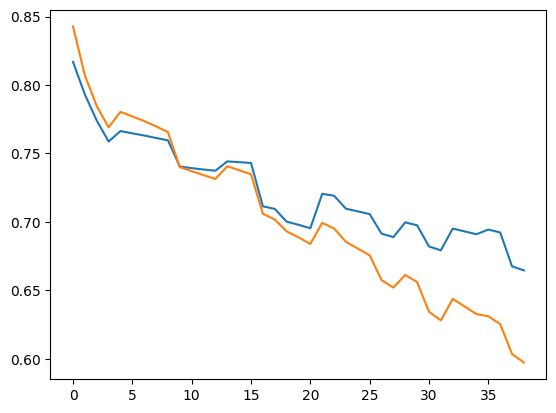

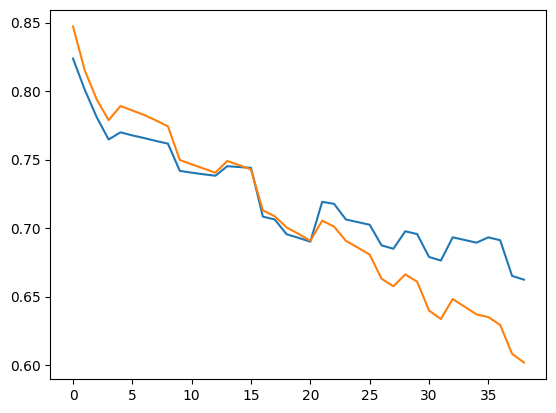

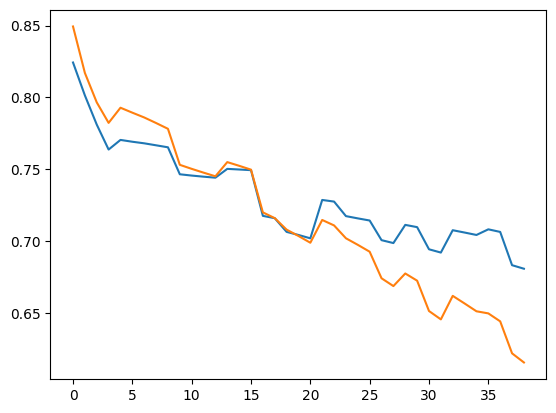

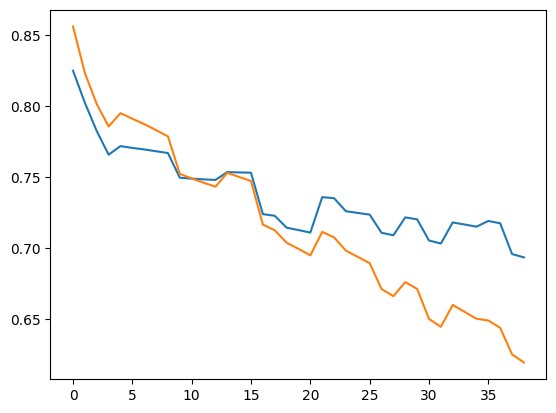

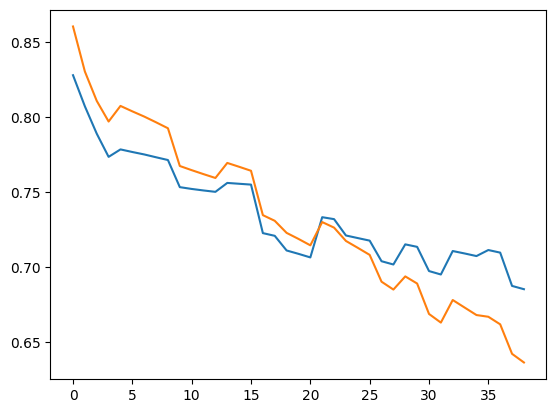

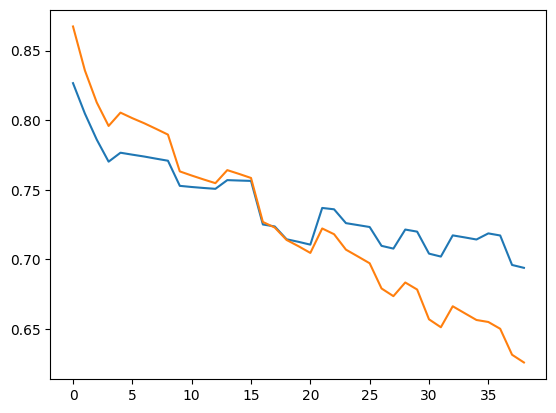

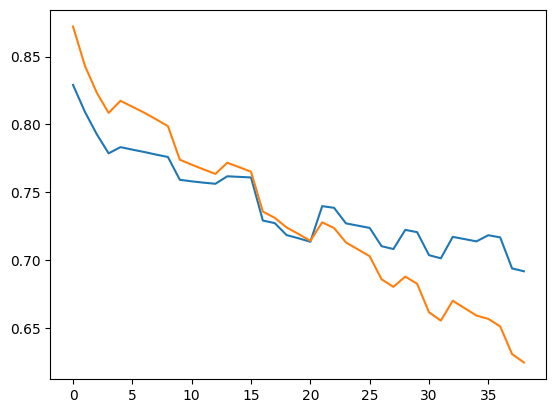

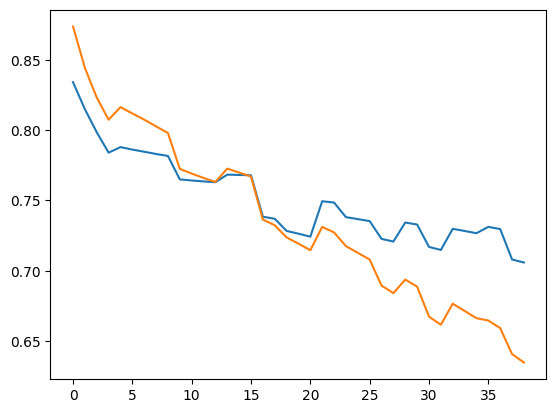

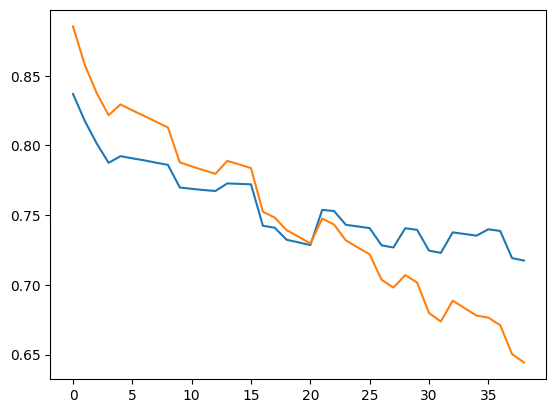

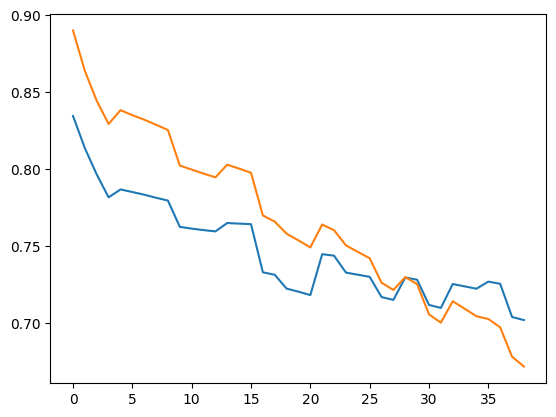

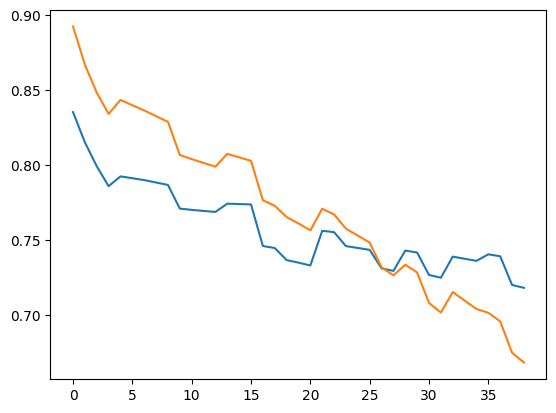

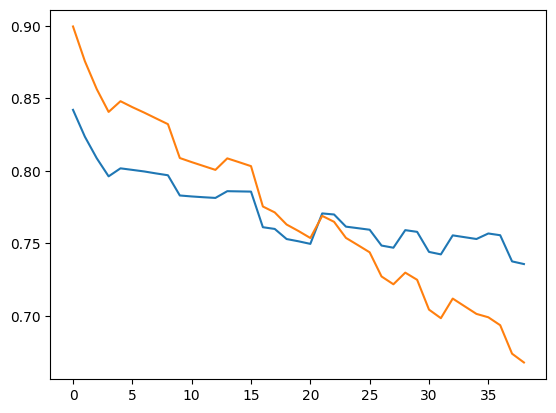

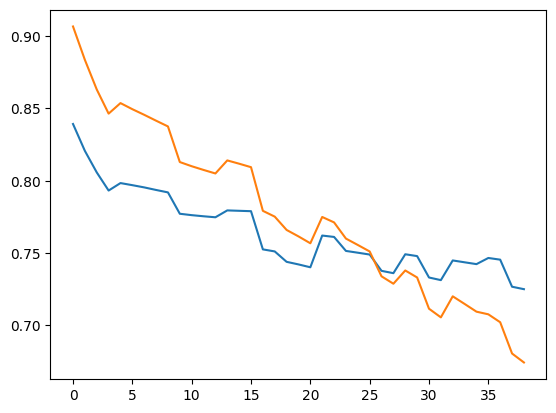

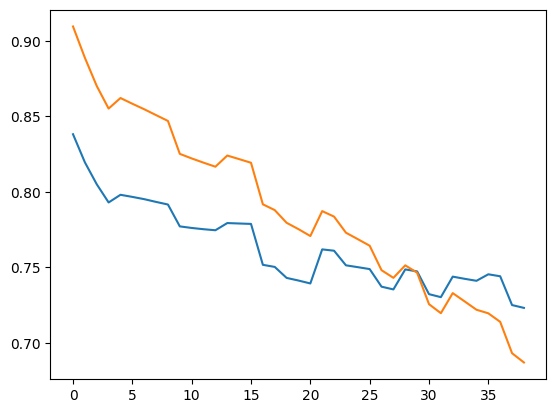

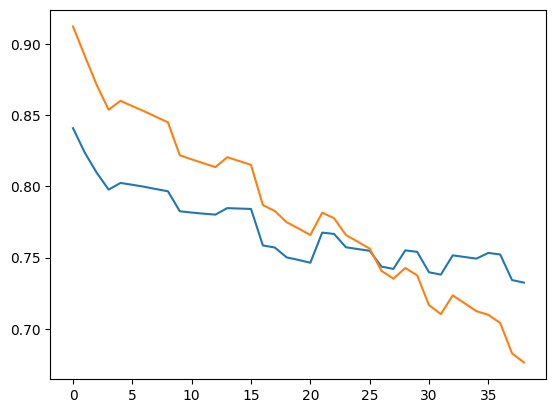

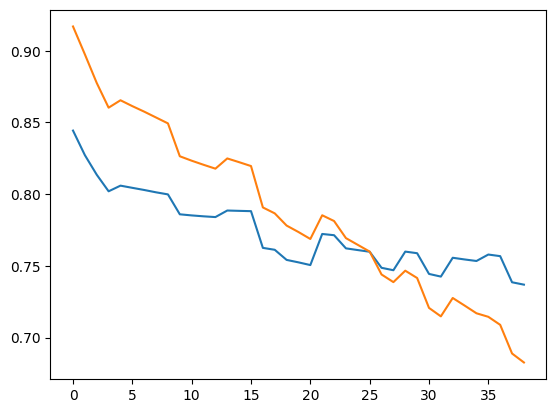

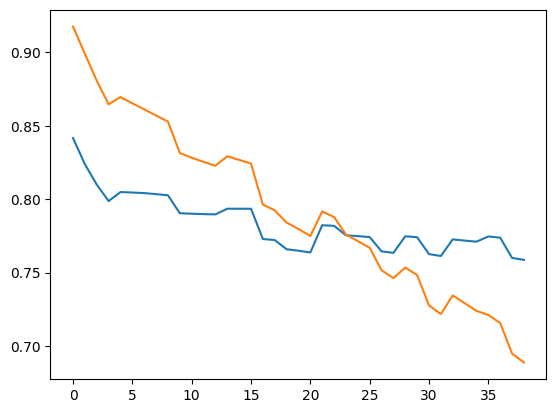

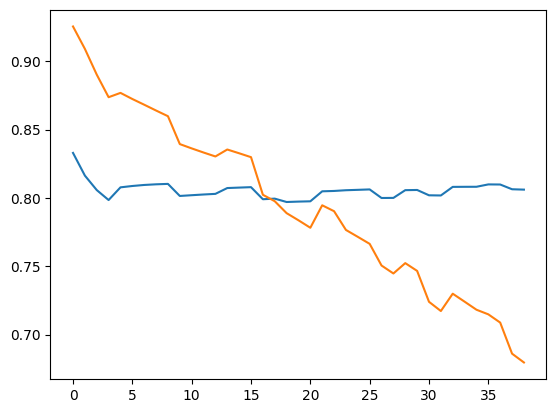

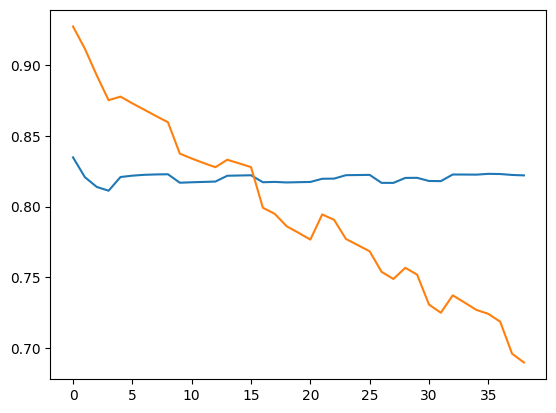

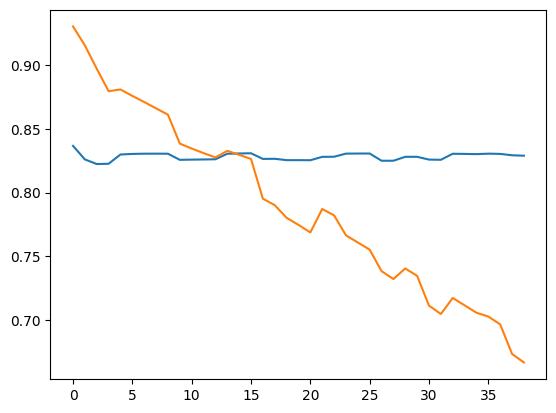

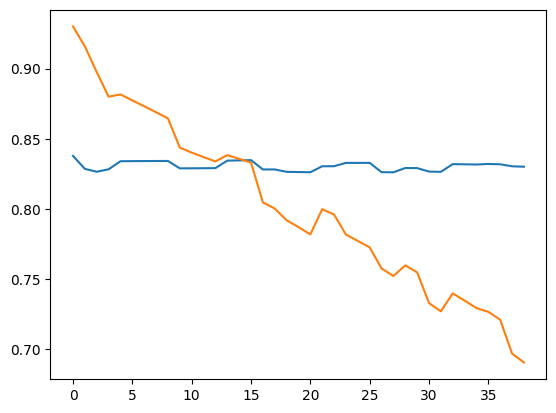

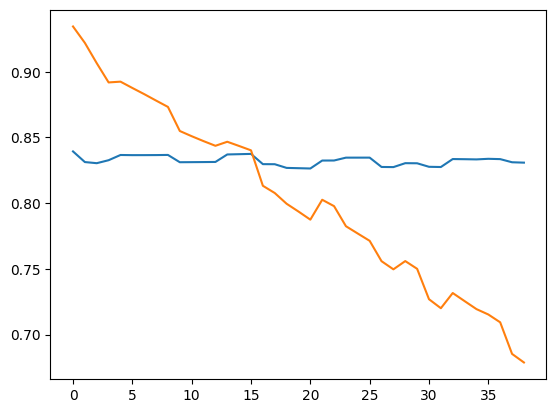

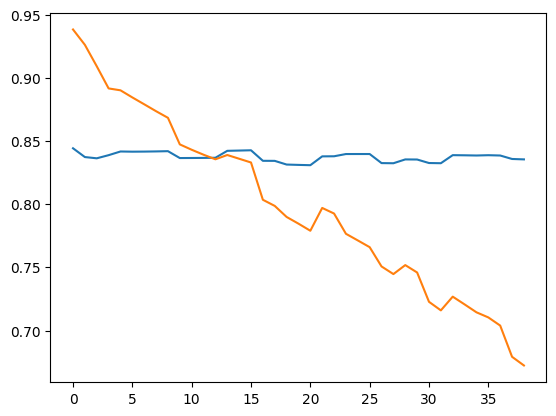

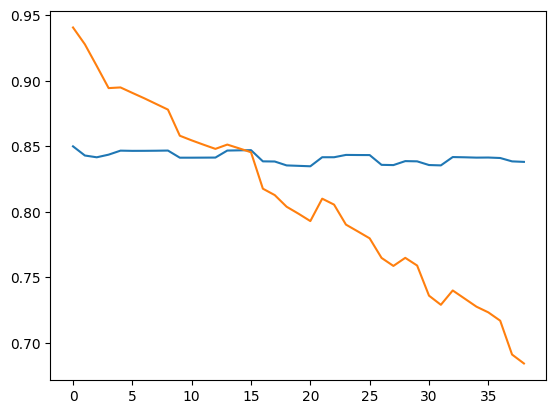

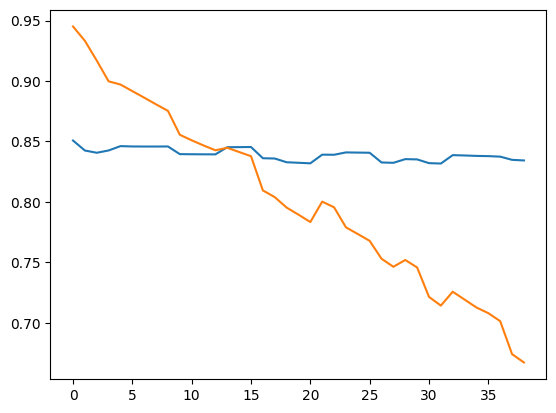

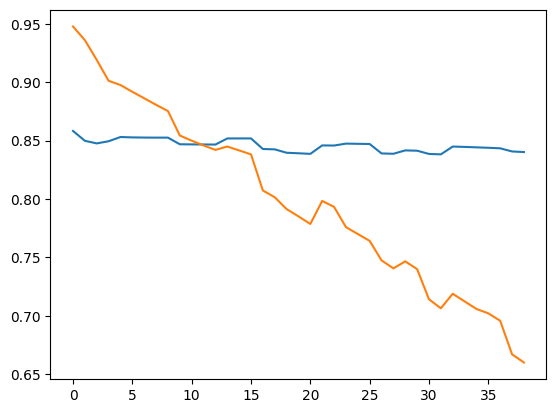

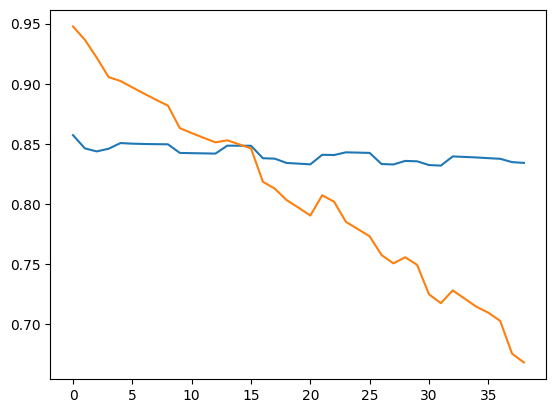

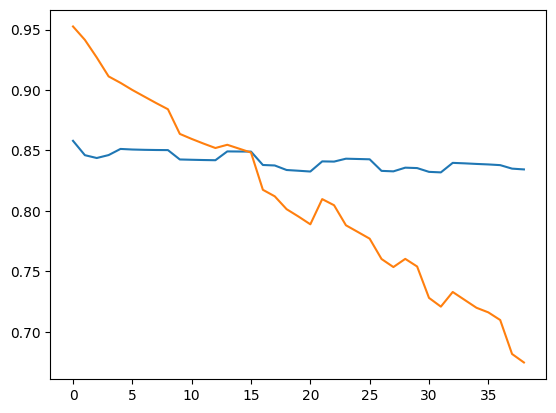

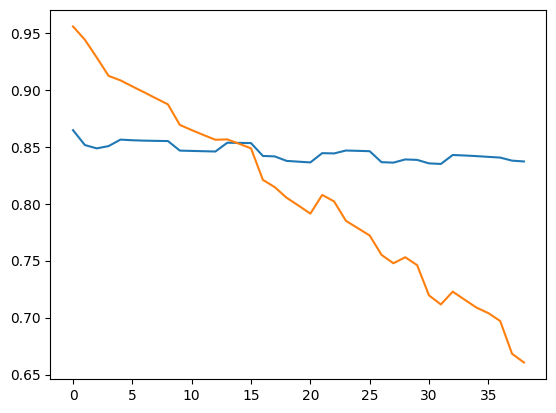

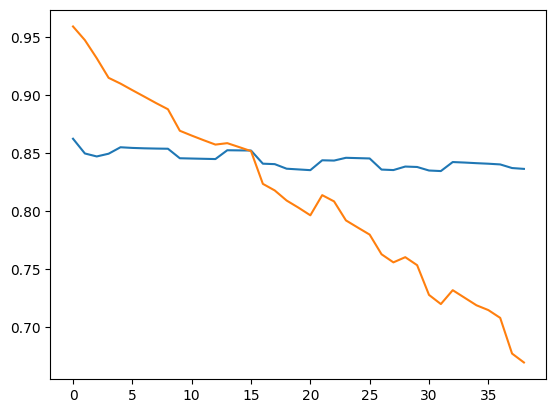

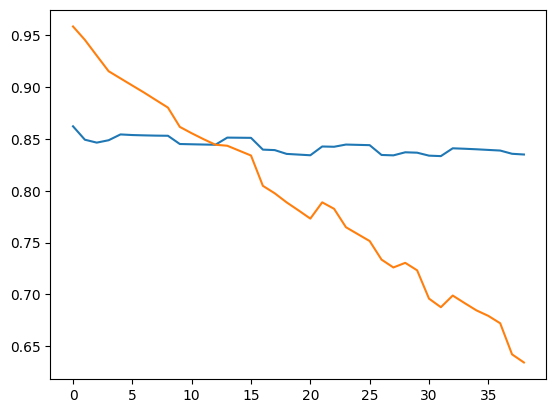

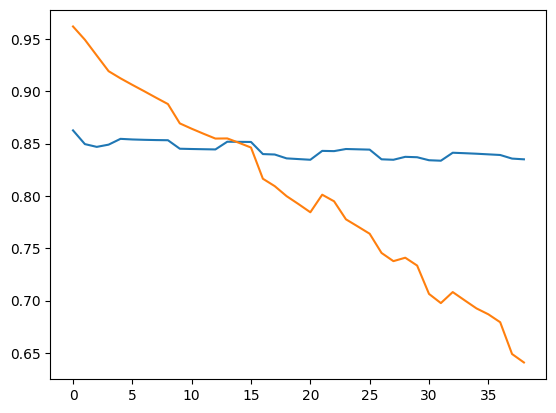

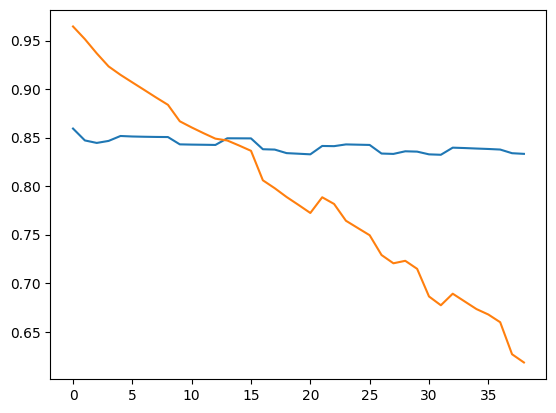

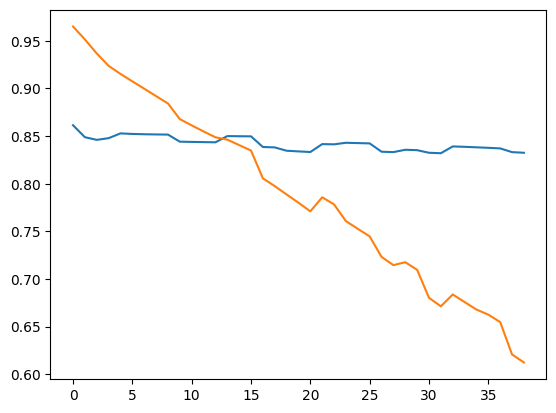

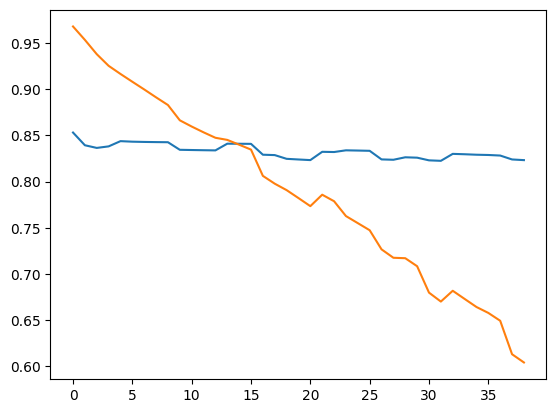

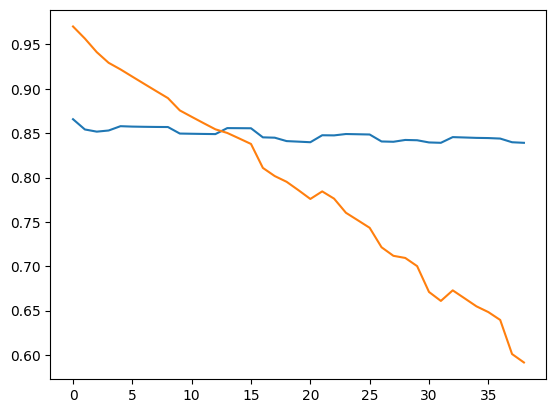

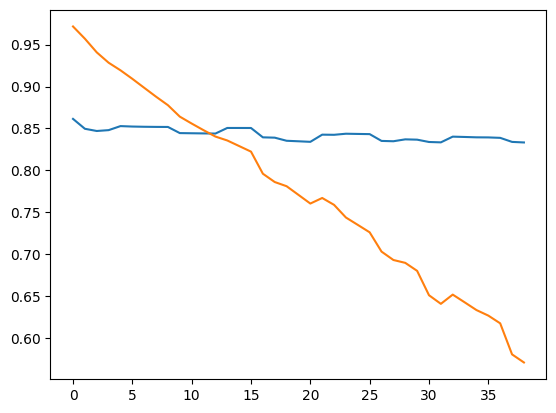

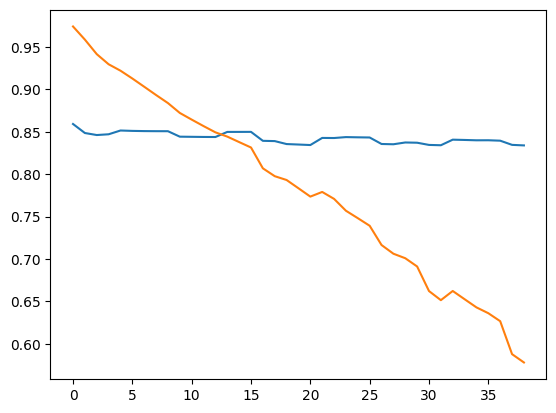

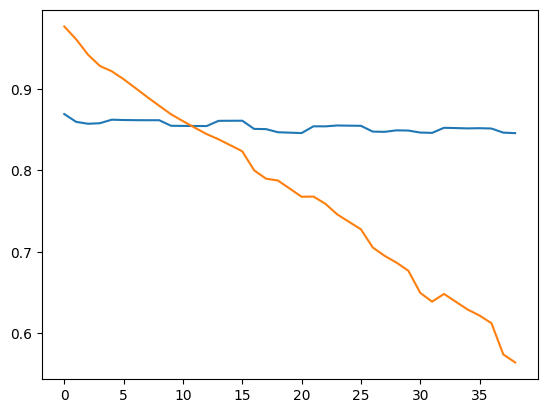

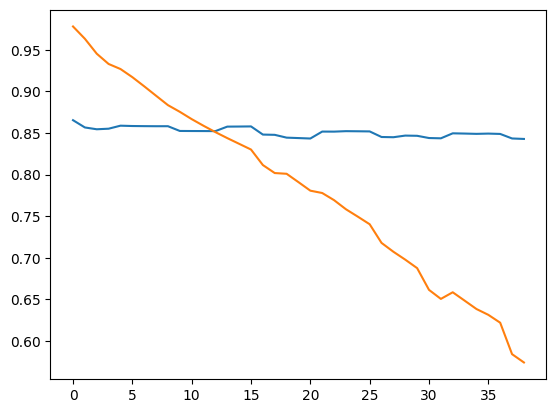

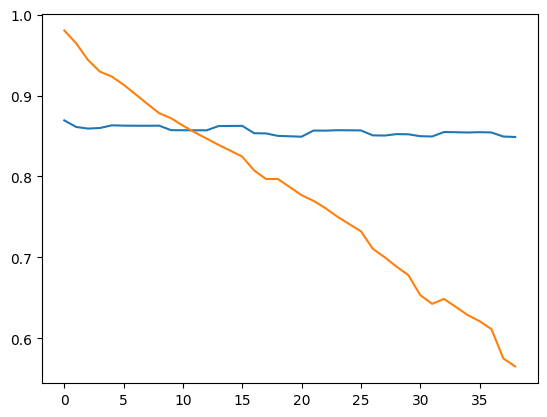

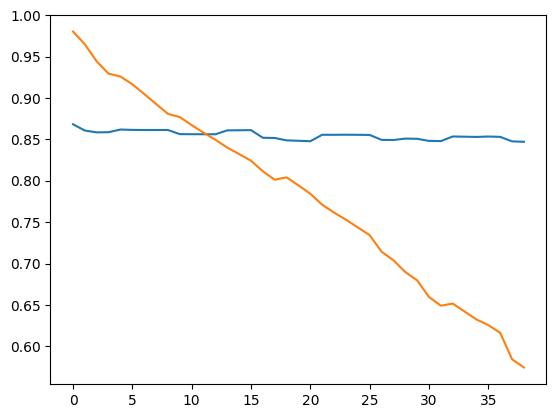

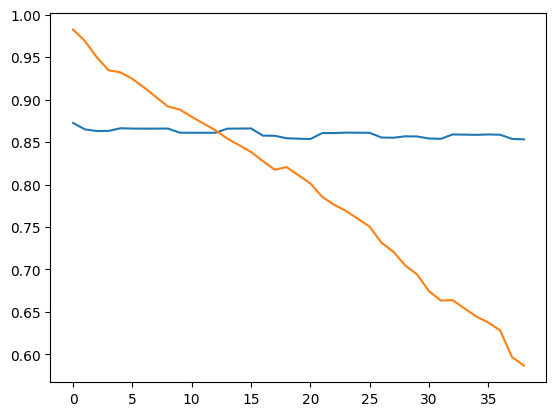

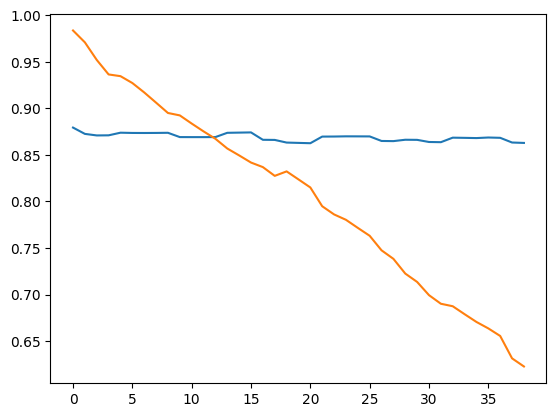

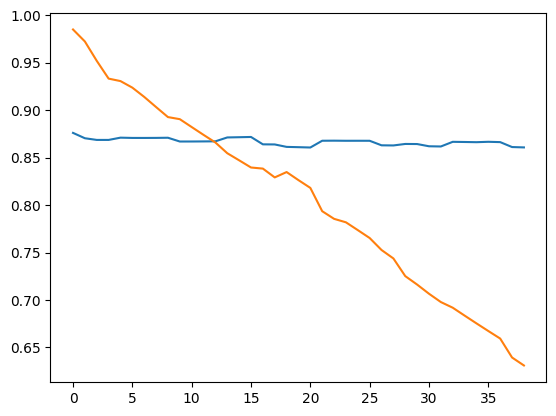

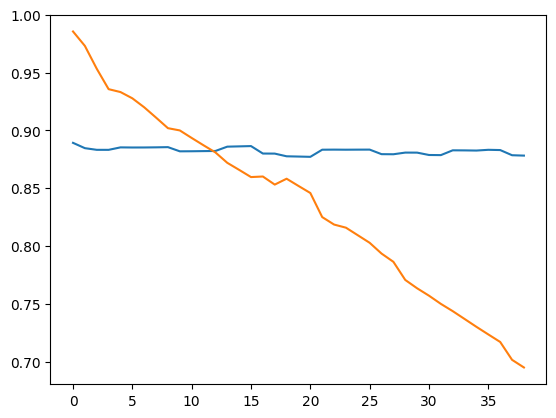

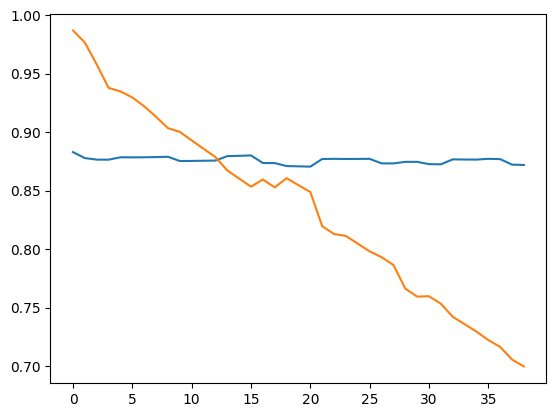

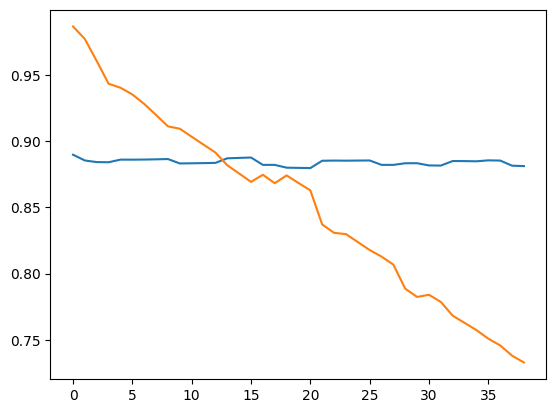

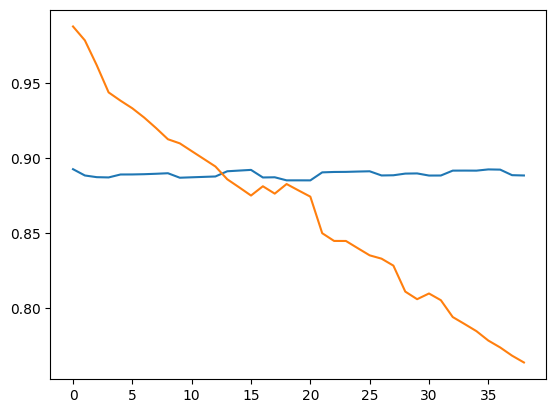

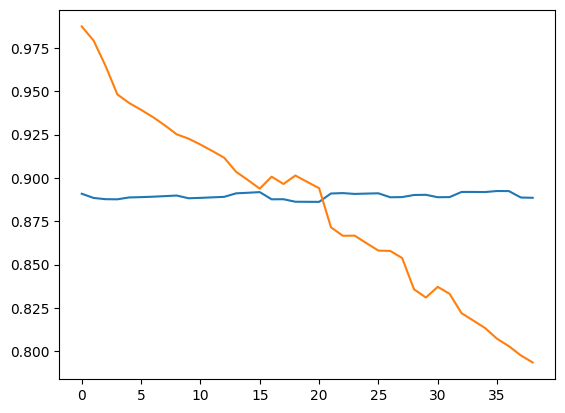

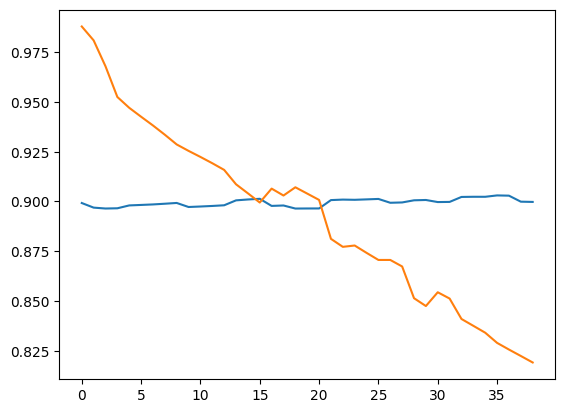

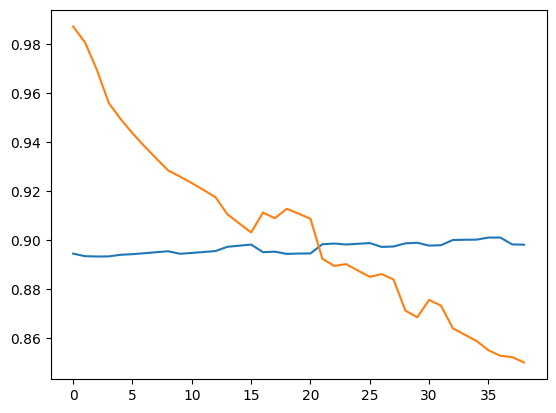

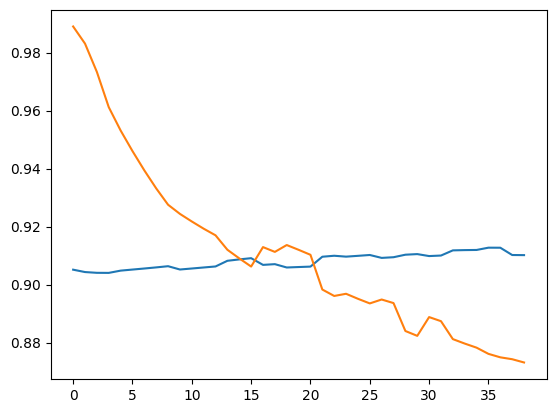

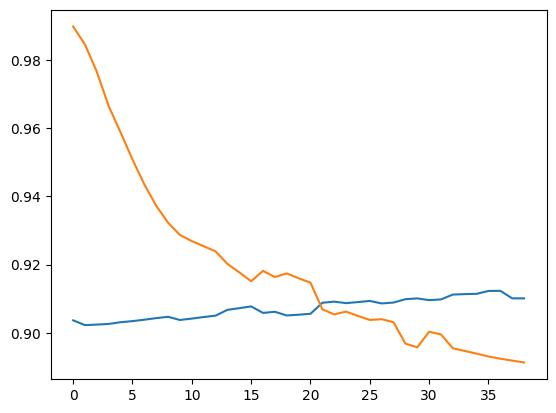

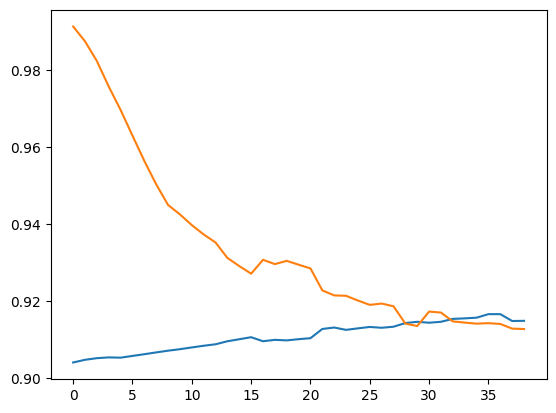

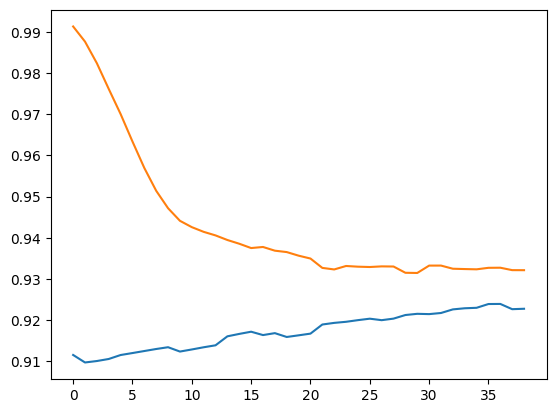

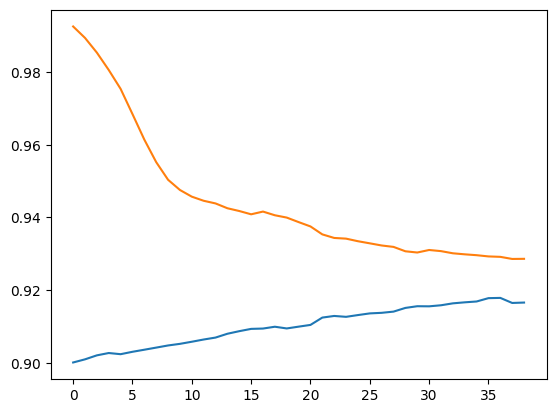

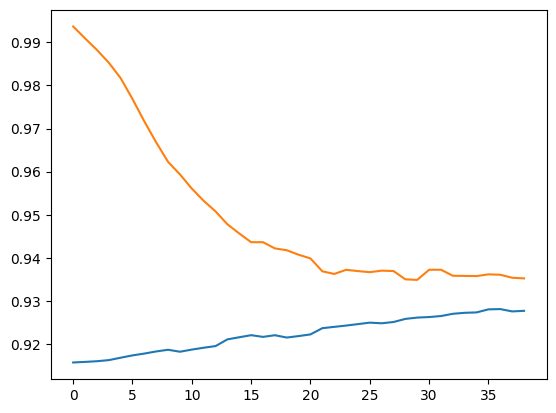

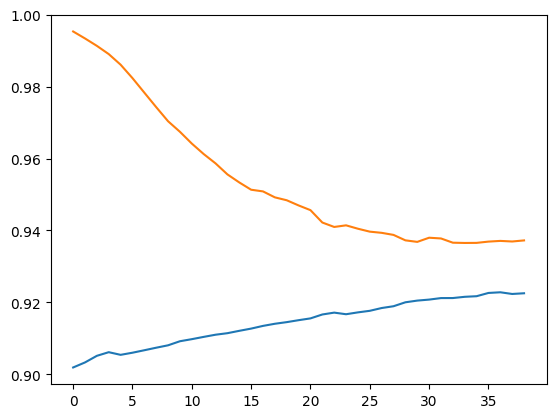

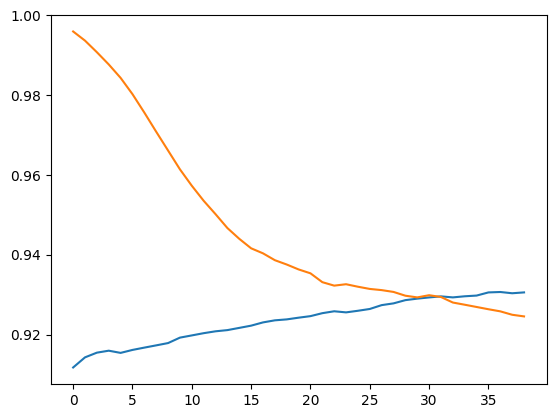

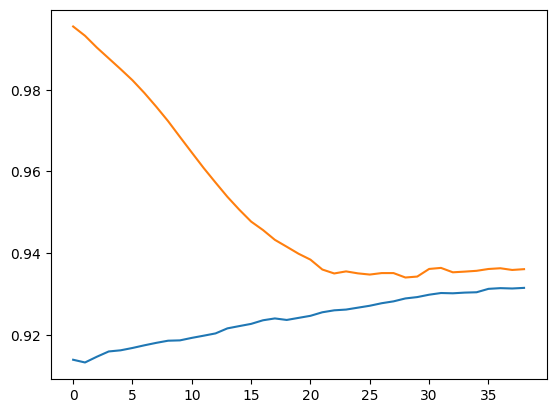

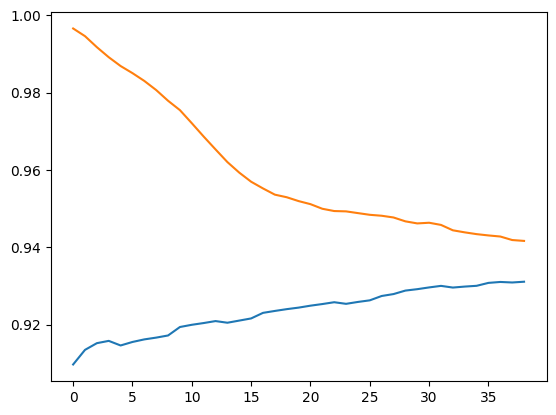

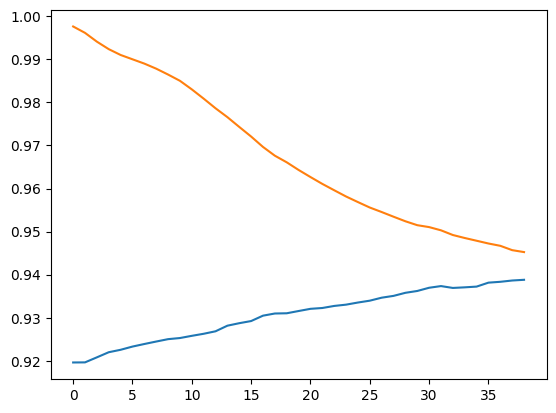

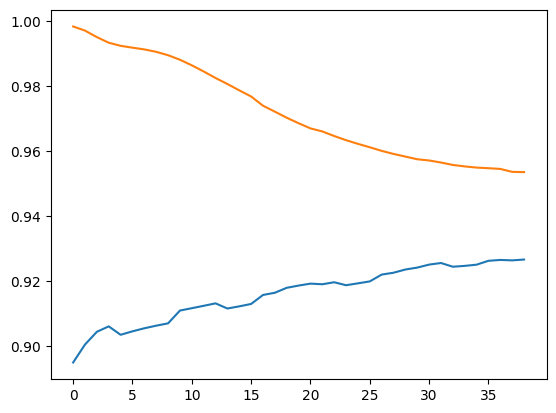

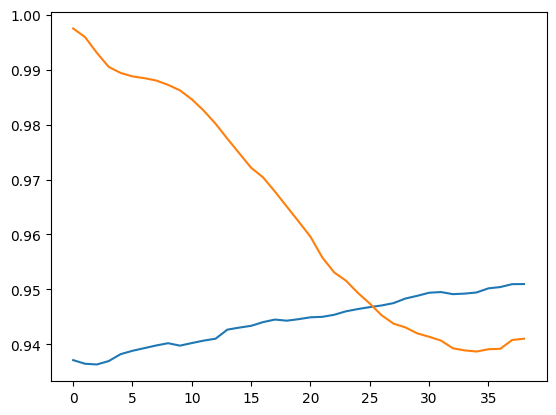

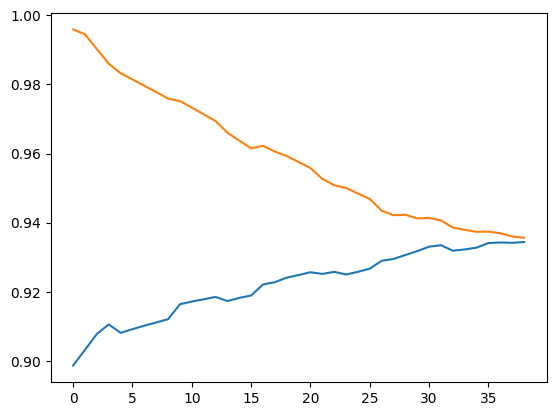

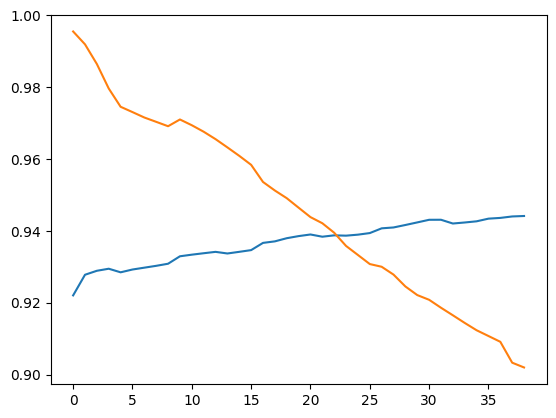

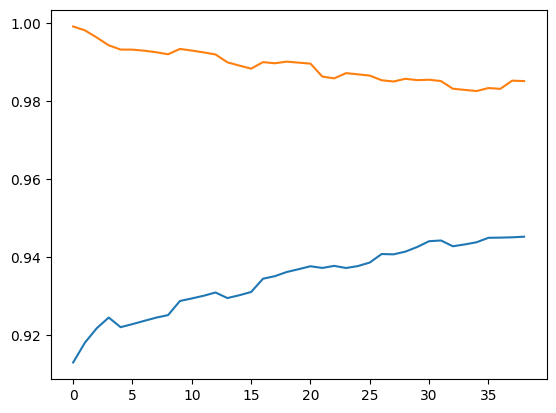

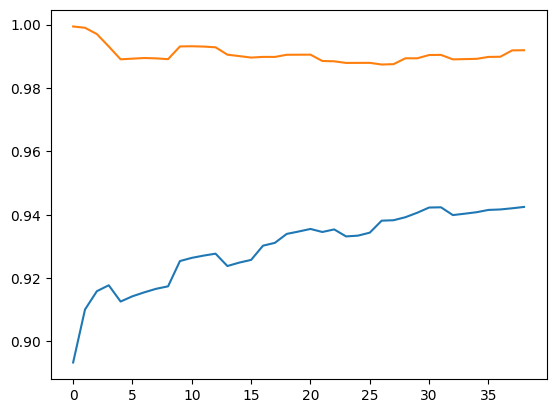

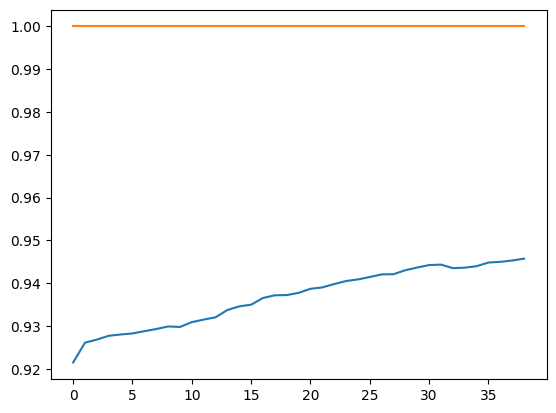

In [80]:
plots = [[fsc[i] for fsc in fsc_list] for i in range(len(fsc_list[0]))]
for i in range(len(plots)):
    plt.plot(plots[i])
    plt.plot(plots[len(plots) - 1 - i])
    plt.show()

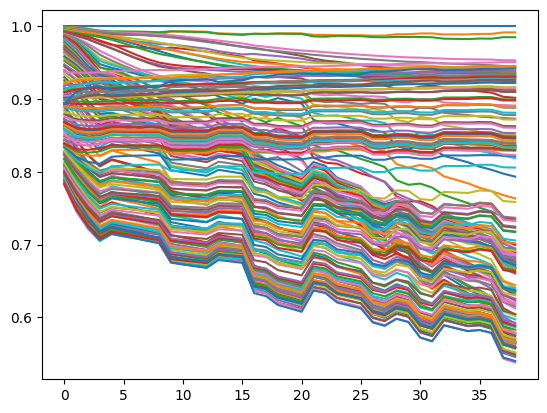

In [81]:
plots = [[fsc[i] for fsc in fsc_list] for i in range(len(fsc_list[0]))]
for i in range(len(plots)):
    plt.plot(plots[i])
plt.show()

In [11]:
fsc_list[0].shape

(83,)

In [307]:
max_gap = gap_list[-1]
self_fsc_list = [self_fsc(x[max_gap : -max_gap or None]) for x in vol_samba]

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


/tmp/ipykernel_2239878/294439288.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn', len(gap_list))


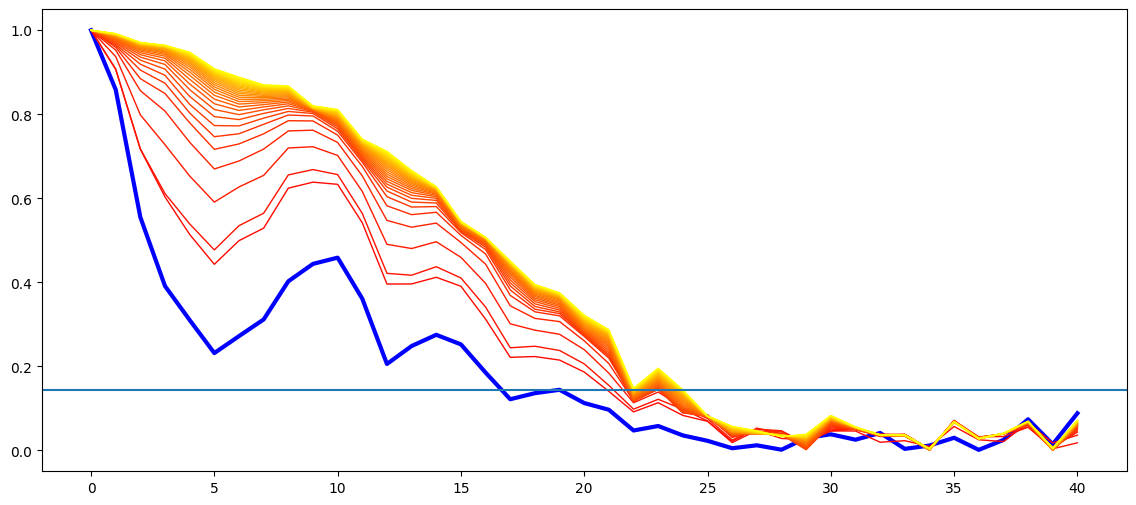

In [309]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.get_cmap("autumn", len(gap_list))
colors = [cmap(i) for i in range(len(gap_list))]
colors[0] = "blue"

plt.figure(figsize=(14, 6))
for fsc, gap, color in zip(self_fsc_list, gap_list, colors):
    plt.plot(fsc, label=str(gap), color=color, linewidth=(3 if color == "blue" else 1))
plt.axhline(y=0.143)
# plt.legend()
plt.show()

# Supp. Fig. 1C

In [77]:
start = time()

path_raw = "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_1x/gap_00/result.rec"

# gap_list = np.arange(0,40,4)
gap_list = np.arange(2, 41)
path_samba = [
    "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_1x/gap_"
    + str(gap).zfill(2)
    + "/result.rec"
    for gap in gap_list
]

pad_z, pad_y, pad_x = [0, 0], [64, 64], [64, 64]
padding = [pad_z, pad_y, pad_x]

vol_raw = l2_normalize(load(path_raw, padding))
vol_samba = [l2_normalize(load(path, padding)) for path in path_samba]

fft_raw = spectrum(vol_raw)
fft_samba = [spectrum(vol) for vol in vol_samba]

print(time() - start)

104.38280129432678


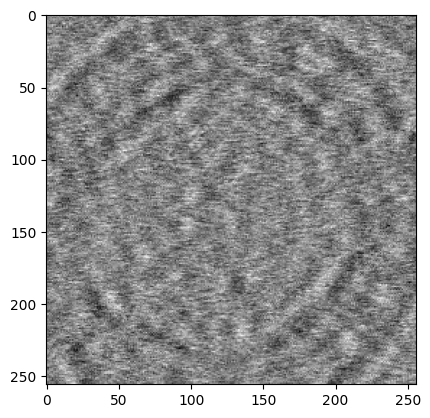

In [193]:
plt.imshow(vol_samba[-1][vol_samba[-1].shape[0] // 2], cmap="grey")
plt.show()

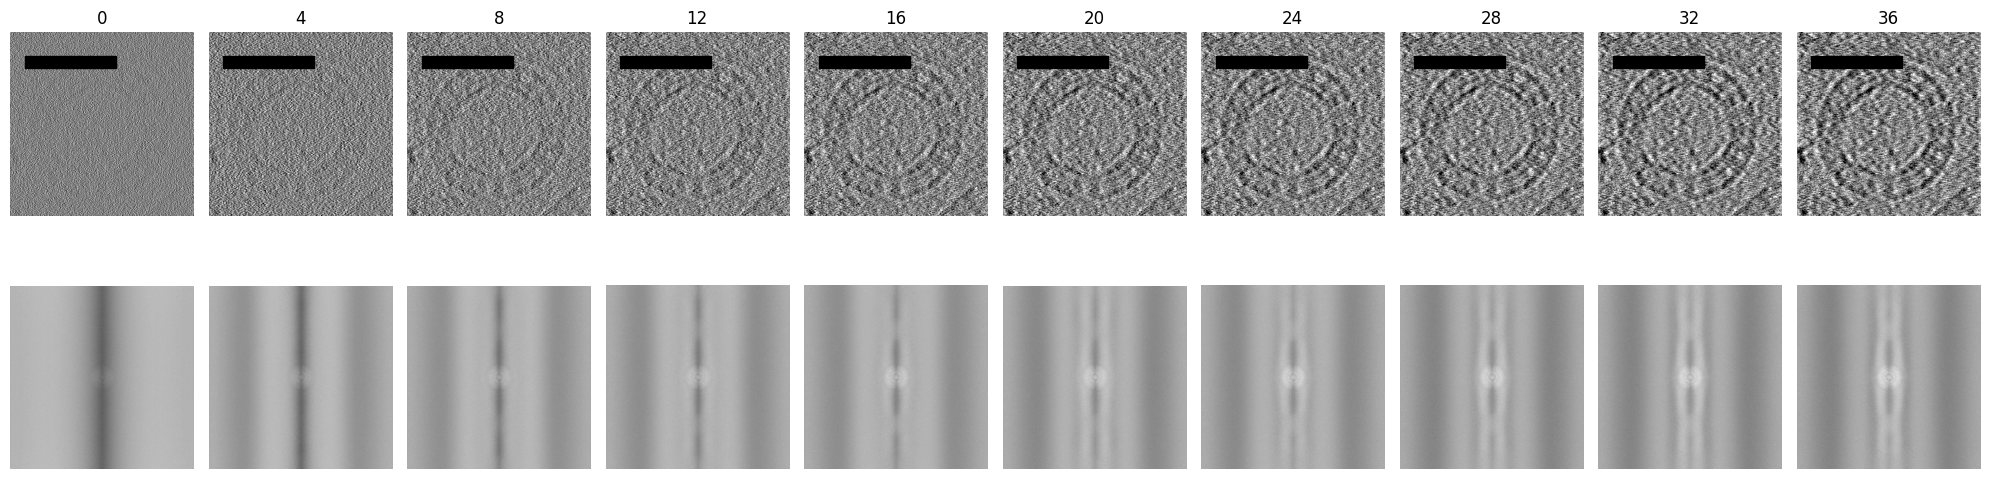

In [63]:
bin = 1
voxel_size = 2.62 * bin
scale_length, scale_width, scale_x0 = 500 / voxel_size, 25 / bin, (30 / bin, 50 / bin)

sigma = 2
vmin, vmax = 0.5 * (np.log(fft_raw)).min(), 0.5 * (np.log(fft_raw)).max()

fig, axs = plt.subplots(2, len(gap_list), figsize=(20, 6))
for i, gap in enumerate(gap_list):
    image = vol_samba[i][vol_samba[i].shape[0] // 2]
    fourier = np.log(fft_samba[i].mean(axis=0))
    img_bounds = sigma_bounds(image, sigma=sigma)

    ax = axs[0, i]
    ax.imshow(image, cmap="grey", vmin=img_bounds[0], vmax=img_bounds[1])
    ax.axis("off")
    ax.set_title(gap)
    scalebar = patches.Rectangle(
        scale_x0,
        scale_length,
        scale_width,
        linewidth=1,
        edgecolor="black",
        facecolor="black",
    )
    ax.add_patch(scalebar)

    ax = axs[1, i]
    ax.imshow(fourier, vmin=vmin, vmax=vmax, cmap="grey")
    ax.axis("off")

plt.tight_layout()
# plt.savefig('supp_fig_1C.svg', format='svg')
plt.show()

# Supp. Fig. 2

In [ ]:
start = time()

path_raw = "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_3x/gap_00/result.rec"

gap_list = np.arange(0, 6)
path_samba = [
    "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_3x/gap_"
    + str(gap).zfill(2)
    + "/result.rec"
    for gap in gap_list
]
path_og = [
    "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_3x/og_gap_"
    + str(gap).zfill(2)
    + "/result.rec"
    for gap in gap_list
]
path_avg = [
    "/nfs/datasync4/inacio/data/denoising/cryosamba/benchmark/virus_3x/avg_gap_"
    + str(gap).zfill(2)
    + "/result.rec"
    for gap in gap_list
]


pad_z, pad_y, pad_x = [0, 0], [70, 70], [63, 77]
padding = [pad_z, pad_y, pad_x]

vol_raw = l2_normalize(load(path_raw, padding))
vol_samba = [l2_normalize(load(path, padding)) for path in path_samba]
vol_og = [l2_normalize(load(path, padding)) for path in path_og]
vol_avg = [l2_normalize(load(path, padding)) for path in path_avg]

fft_raw = spectrum(vol_raw)
fft_samba = [spectrum(vol) for vol in vol_samba]
fft_og = [spectrum(vol) for vol in vol_og]
fft_avg = [spectrum(vol) for vol in vol_avg]

print(time() - start)

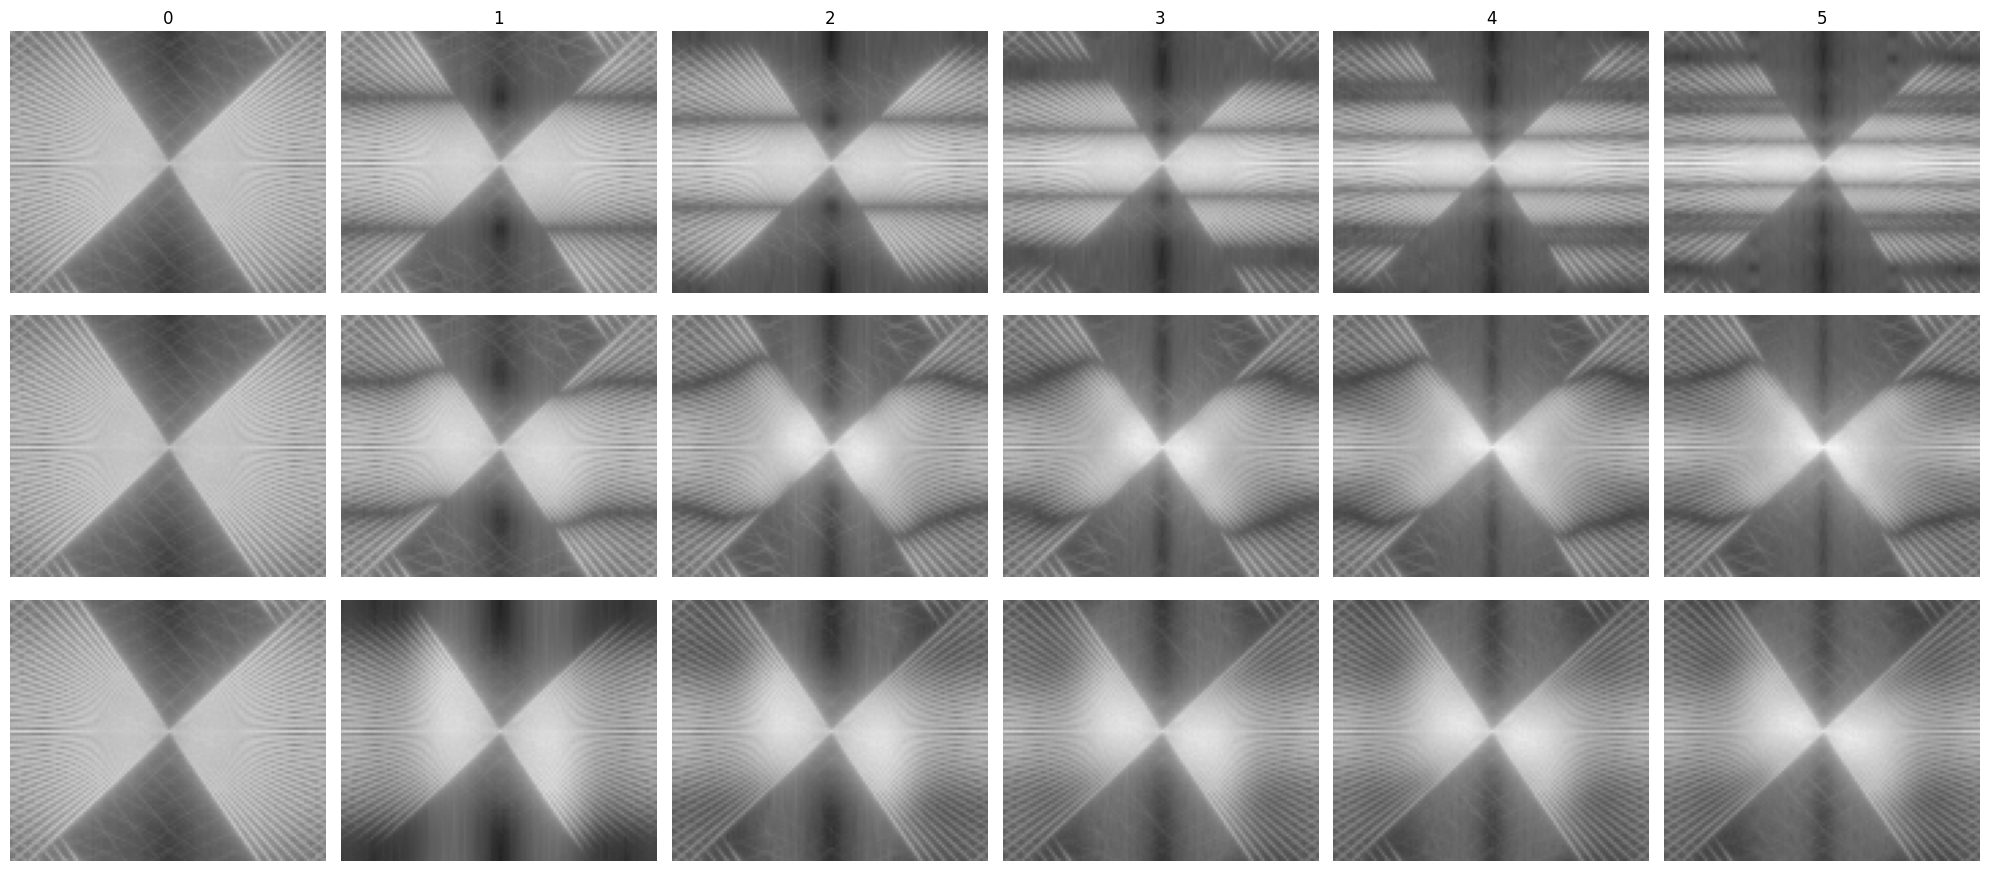

In [170]:
vmin, vmax = 0.5 * (np.log(fft_raw)).min(), 0.5 * (np.log(fft_raw)).max()

fig, axs = plt.subplots(3, len(gap_list), figsize=(20, 9))
for i, gap in enumerate(gap_list):
    fourier = np.log(fft_samba[i].mean(axis=1))
    fourier_og = np.log(fft_og[i].mean(axis=1))
    fourier_avg = np.log(fft_avg[i].mean(axis=1))

    ax = axs[0, i]
    ax.imshow(fourier_avg, vmin=vmin, vmax=vmax, cmap="grey")
    ax.axis("off")
    ax.set_title(gap)

    ax = axs[1, i]
    ax.imshow(fourier_og, vmin=vmin, vmax=vmax, cmap="grey")
    ax.axis("off")

    ax = axs[2, i]
    ax.imshow(fourier, vmin=vmin, vmax=vmax, cmap="grey")
    ax.axis("off")

plt.tight_layout()
# plt.savefig('supp_fig_2.svg', format='svg')
plt.show()